# 3. Semantic Segmentation using U-Net

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from tqdm import tqdm
import wandb
import torchmetrics
from torchmetrics.segmentation import MeanIoU
from matplotlib.colors import ListedColormap
import random

/home2/kushang/miniconda3/envs/metal_chelate/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!unzip seg_dataset_256.zip

Archive:  seg_dataset_256.zip
   creating: dataset_256/test/
   creating: dataset_256/test/images/
  inflating: dataset_256/test/images/02_00_009.png  
  inflating: dataset_256/test/images/02_00_019.png  
  inflating: dataset_256/test/images/02_00_029.png  
  inflating: dataset_256/test/images/02_00_039.png  
  inflating: dataset_256/test/images/02_00_049.png  
  inflating: dataset_256/test/images/02_00_059.png  
  inflating: dataset_256/test/images/02_00_069.png  
  inflating: dataset_256/test/images/02_00_079.png  
  inflating: dataset_256/test/images/02_00_089.png  
  inflating: dataset_256/test/images/02_00_099.png  
  inflating: dataset_256/test/images/02_00_109.png  
  inflating: dataset_256/test/images/02_00_119.png  
  inflating: dataset_256/test/images/02_00_129.png  
  inflating: dataset_256/test/images/02_00_139.png  
  inflating: dataset_256/test/images/02_00_149.png  
  inflating: dataset_256/test/images/02_00_159.png  
  inflating: dataset_256/test/images/02_00_169.png  


In [2]:
classes = {
    0: "Unlabeled",
    1: "Building",
    2: "Fence",
    3: "Other",
    4: "Pedestrian",
    5: "Pole",
    6: "Roadline",
    7: "Road",
    8: "Sidewalk",
    9: "Vegetation",
    10: "Car",
    11: "Wall",
    12: "Traffic sign"
}

In [4]:
# LLM - how to plot images using axes in matplotlib

def visualize_segmentation_classes(image_path, mask_path):

    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)
    mask = Image.open(mask_path)
    mask_np = np.array(mask)[:, :, 0]

    fig, axes = plt.subplots(2, 7, figsize=(18, 10))
    axes = axes.flatten()

    axes[0].imshow(image_np)
    axes[0].set_title("Original Image")
    axes[0].axis('off')


    for class_id in range(13):
        binary_mask = (mask_np == class_id).astype(np.uint8)
        ax = axes[class_id+1]
        ax.imshow(binary_mask, cmap='gray')
        ax.set_title(f"{class_id}: {classes[class_id]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [5]:
train_image_folder = "dataset_256/train/images"

for i, file_name in enumerate(os.listdir(train_image_folder)):
    img_path = os.path.join(train_image_folder, file_name)
    image=Image.open(img_path).convert("RGB")
    print(f"Size of an Image in this dataset : {image.size}")
    break

Size of an Image in this dataset : (256, 256)


### Visualizing a few examples from the dataset and their segmentation masks class-wise

Image Path: dataset_224/train/images/F1-93.png


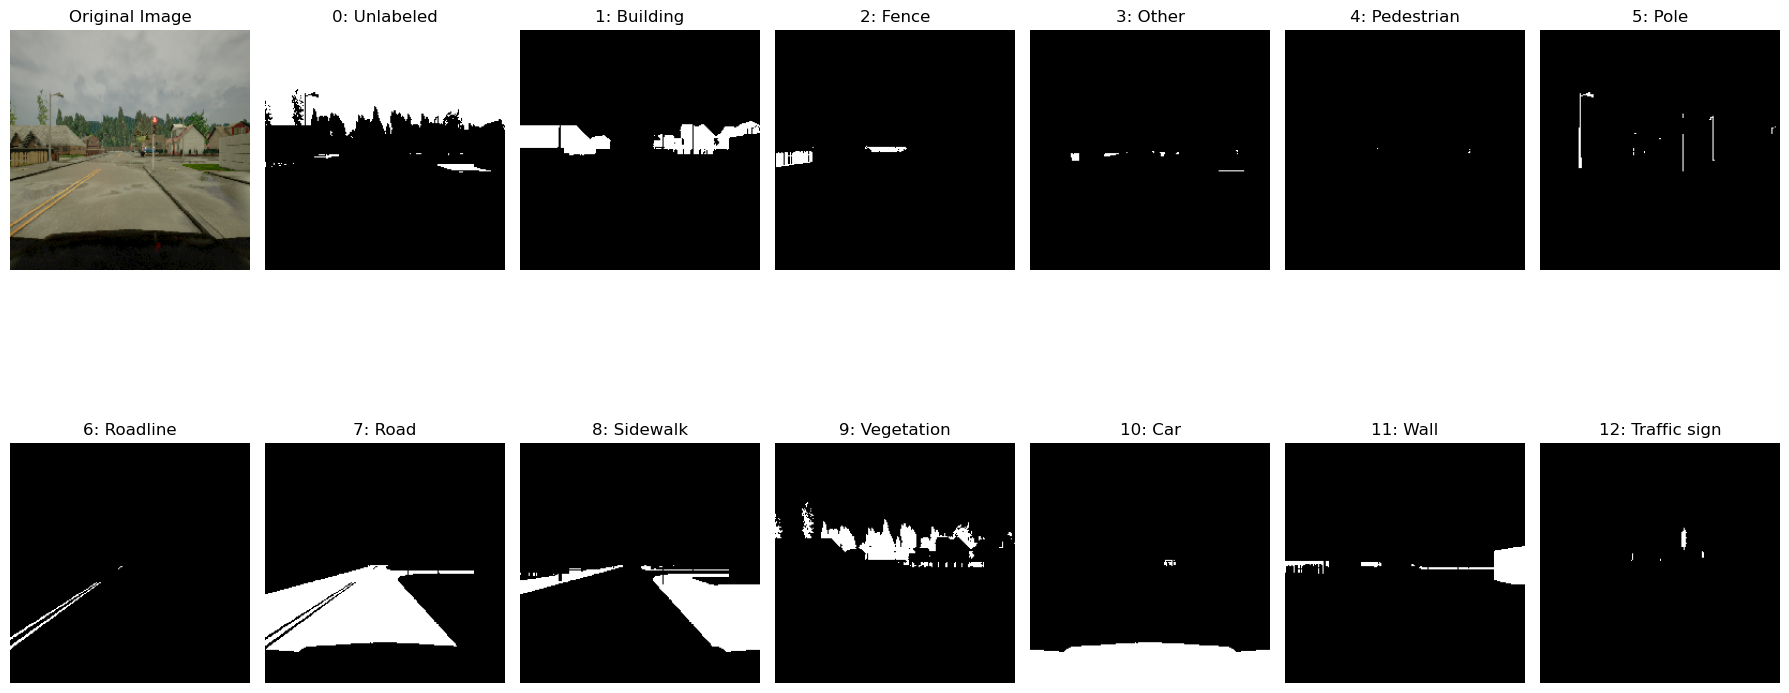

Image Path: dataset_224/train/images/02_02_051.png


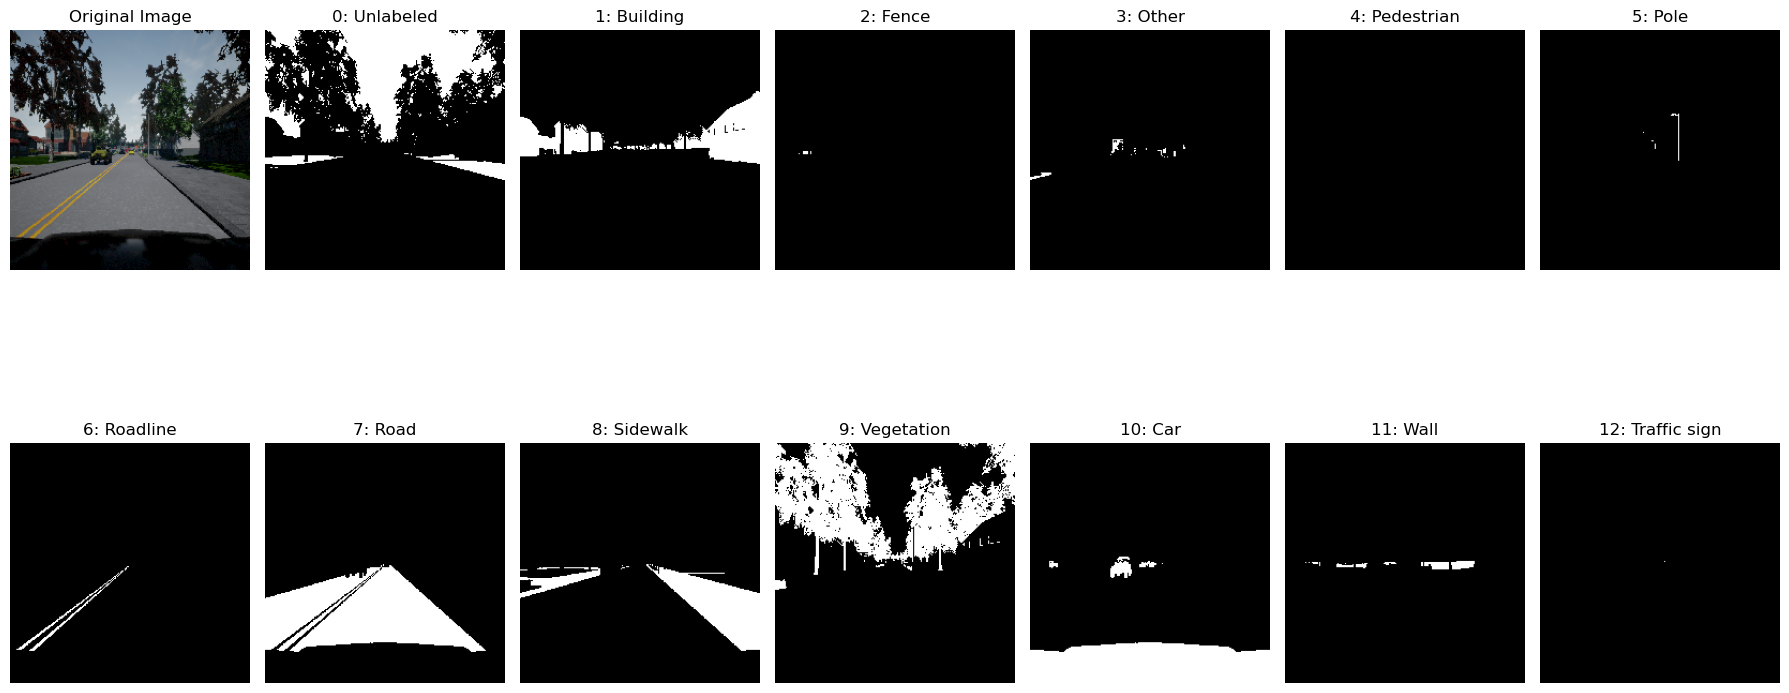

Image Path: dataset_224/train/images/F62-63.png


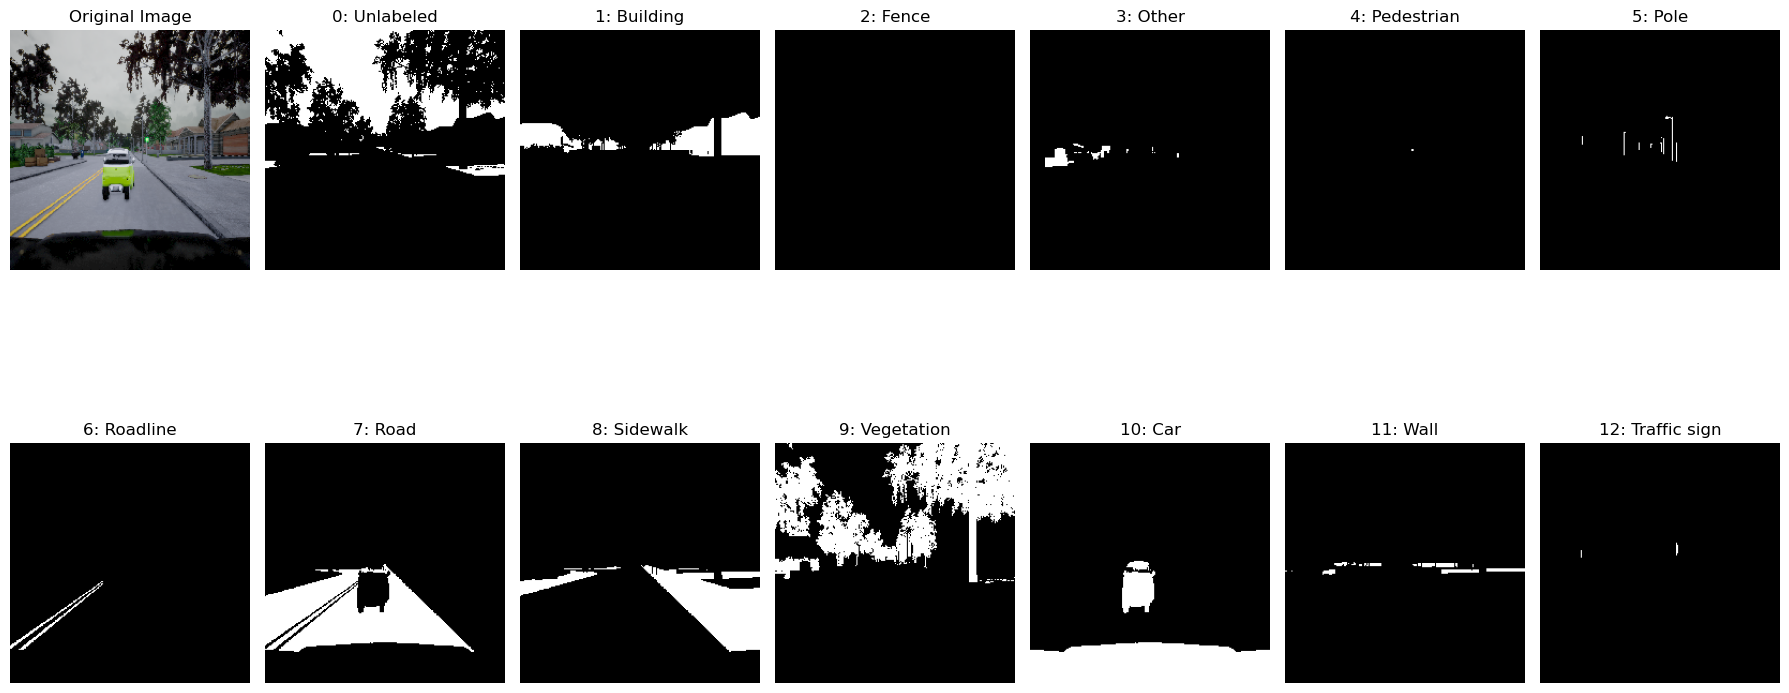

Image Path: dataset_224/train/images/04_00_143.png


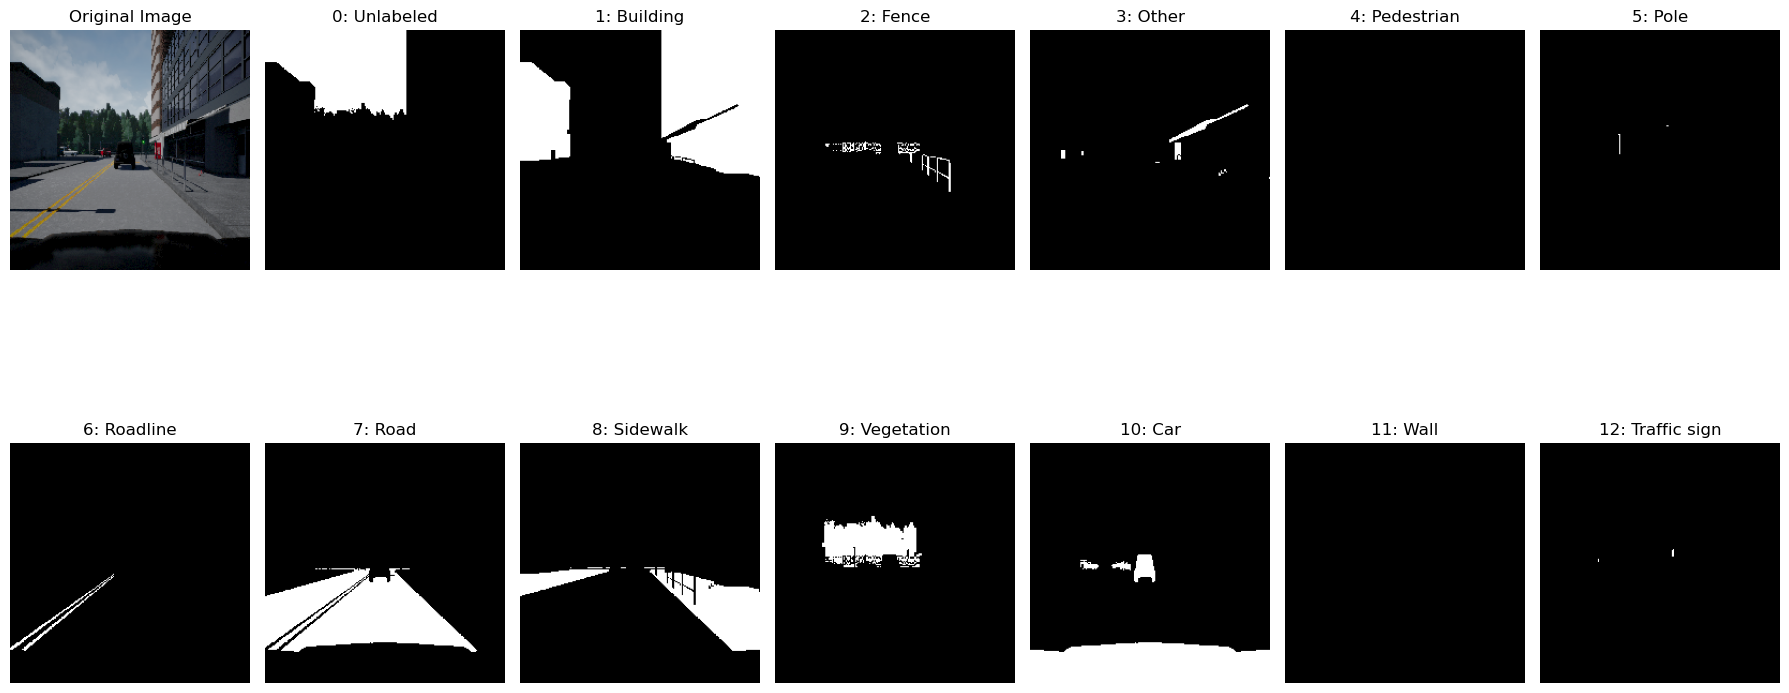

Image Path: dataset_224/train/images/F8-63.png


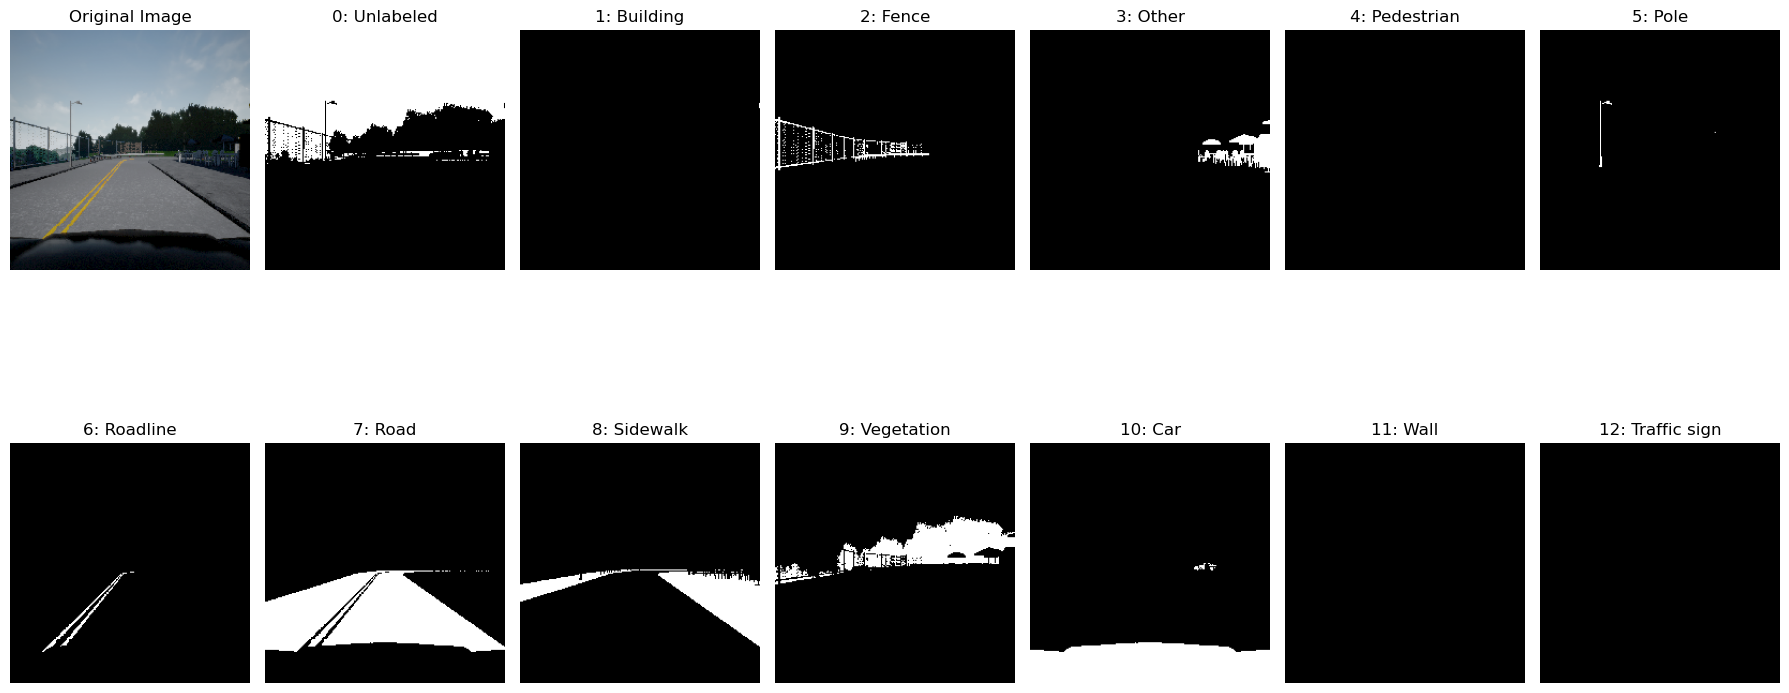

In [6]:
train_image_folder = "dataset_224/train/images"
train_mask_folder = "dataset_224/train/labels"

for i, file_name in enumerate(os.listdir(train_image_folder)):
    if i%400==0:
        img_path = os.path.join(train_image_folder, file_name)
        mask_path = os.path.join(train_mask_folder, file_name)
        print(f"Image Path: {img_path}")
        visualize_segmentation_classes(img_path, mask_path)
    if i>1800:
        break


In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = sorted(os.listdir(image_dir))
        if transform:
            self.transform = transform
        else:
            self.transform = T.Compose([
                            T.ToTensor()
                        ])
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)[:, :, 0]

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            mask = torch.from_numpy(mask).long()

        return image, mask


In [4]:
train_dataset = SegmentationDataset(
    image_dir='dataset_256/train/images',
    mask_dir='dataset_256/train/labels',
)

test_dataset = SegmentationDataset(
    image_dir='dataset_256/test/images',
    mask_dir='dataset_256/test/labels',
)

train_size = int(0.9*len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

print("Number of training samples : ", train_size)
print("Number of validation samples :", val_size)
print("Number of test samples : ", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

Number of training samples :  1800
Number of validation samples : 200
Number of test samples :  500


In [5]:
# LLM - help me implement early stopping here.
# LLM - how to use miou from torchmetrics library in my training loop

def train_model(model, train_loader, val_loader, device, epochs = 50, lr = 0.0001, patience = 10):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    iou_metric = MeanIoU(num_classes=13).to(device)

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):

      model.train()
      train_loss = 0.0

      for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):

        inputs, labels = inputs.to(device), labels.to(device)
        inputs=inputs.float()
        labels=labels.long()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred_masks = torch.argmax(outputs, dim=1)
        target_masks = labels.int()
        iou_metric.update(pred_masks, target_masks)

      avg_train_loss = train_loss/len(train_loader)
      iou_results = iou_metric.compute()
      train_miou = iou_results.item()

      iou_metric.reset()

      model.eval()
      val_loss = 0.0

      with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
          inputs, labels = inputs.to(device), labels.to(device)
          inputs=inputs.float()
          labels=labels.long()

          outputs = model(inputs)
          loss = criterion(outputs, labels)

          val_loss += loss.item()
          pred_masks = torch.argmax(outputs, dim=1)
          target_masks = labels.int()
          iou_metric.update(pred_masks, target_masks)

      avg_val_loss = val_loss/len(val_loader)
      iou_results = iou_metric.compute()
      val_miou = iou_results.item()

      iou_metric.reset()

      print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train mIoU: {train_miou:.4f}, Val mIoU: {val_miou:.4f}')
      wandb.log({"train_loss": avg_train_loss, "val_loss": avg_val_loss, "train_miou": train_miou, "val_miou": val_miou})

      if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
      else:
          patience_counter += 1
          if patience_counter >= patience:
              print(f"Early stopping at epoch {epoch+1} — no improvement for {patience} consecutive epochs.")
              break

    # Load best model before returning
    if best_model_state:
        model.load_state_dict(best_model_state)

    return model

In [6]:
color_list = [
    "#e6194b", "#3cb44b", "#ffe119", "#4363d8", "#f58231",
    "#911eb4", "#46f0f0", "#f032e6", "#bcf60c", "#fabebe",
    "#008080", "#e6beff", "#9a6324"
]
custom_cmap = ListedColormap(color_list)

In [7]:
def evaluate_and_visualize(model, test_loader, device, num_classes=13, num_samples=5):
    model.eval()
    model.to(device)
    iou_metric = MeanIoU(num_classes=num_classes).to(device)

    all_images = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.float()

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            iou_metric.update(preds, labels.int())

            for img, gt_mask, pred_mask in zip(inputs, labels, preds):
                all_images.append((img.cpu(), gt_mask.cpu(), pred_mask.cpu()))

    # Compute final mIoU
    miou = iou_metric.compute().item()
    print(f"\nMean IoU on Test Set: {miou:.4f}")

    # Pick `num_samples` random images for visualization
    images_to_plot = random.sample(all_images, min(num_samples, len(all_images)))

    # Visualization
    for i, (img, gt_mask, pred_mask) in enumerate(images_to_plot):
        img_np = img.permute(1, 2, 0).numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img_np)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask, cmap=custom_cmap, vmin=0, vmax=12)
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap=custom_cmap, vmin=0, vmax=12)
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kushang (kushang-international-institute-of-information-technolog). Use `wandb login --relogin` to force relogin


True

## 3.1 Vanilla U-Net

#### Individual blocks 

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self):
        super().__init__()
        self.down = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        return self.down(x)
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x_decoder, x_encoder):  # x_decoder is from decoder, x_encoder is from encoder (skip)
        x_decoder = self.up(x_decoder)
        x = torch.cat([x_encoder, x_decoder], dim=1)
        return self.conv(x)

class out_conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

#### U-Net

In [11]:
class Vanilla_UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down()
        self.enc1 = DoubleConv(64, 128)
        self.down2 = Down()
        self.enc2 = DoubleConv(128, 256)
        self.down3 = Down()
        self.enc3 = DoubleConv(256, 512)
        self.down4 = Down()
        self.enc4 = DoubleConv(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = out_conv(64, out_channels)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.enc1(x2)
        x4 = self.down2(x3)
        x5 = self.enc2(x4)
        x6 = self.down3(x5)
        x7 = self.enc3(x6)
        x8 = self.down4(x7)
        x9 = self.enc4(x8)

        x10 = self.up1(x9, x7)
        x11 = self.up2(x10, x5)
        x12 = self.up3(x11, x3)
        x13 = self.up4(x12, x1)

        logits = self.outc(x13)

        return logits

#### Training loop

In [16]:
vanilla_unet = Vanilla_UNet(in_channels=3, out_channels=13)
wandb.init(project='Vanilla_UNet',name="classic")
vanilla_unet_trained = train_model(vanilla_unet, train_loader, val_loader, device)
wandb.finish()

Validation Epoch 1: 100%|██████████| 25/25 [00:02<00:00, 12.30it/s]


Epoch [1/50], Train Loss: 0.9862, Val Loss: 0.6301, Train mIoU: 0.7404, Val mIoU: 0.8477


Validation Epoch 2: 100%|██████████| 25/25 [00:02<00:00, 12.21it/s]


Epoch [2/50], Train Loss: 0.4743, Val Loss: 0.3729, Train mIoU: 0.8566, Val mIoU: 0.8804


Validation Epoch 3: 100%|██████████| 25/25 [00:02<00:00, 12.03it/s]


Epoch [3/50], Train Loss: 0.3221, Val Loss: 0.2833, Train mIoU: 0.8813, Val mIoU: 0.8916


Validation Epoch 4: 100%|██████████| 25/25 [00:02<00:00, 12.09it/s]


Epoch [4/50], Train Loss: 0.2587, Val Loss: 0.2180, Train mIoU: 0.8905, Val mIoU: 0.9098


Validation Epoch 5: 100%|██████████| 25/25 [00:02<00:00, 12.10it/s]


Epoch [5/50], Train Loss: 0.1968, Val Loss: 0.1764, Train mIoU: 0.9103, Val mIoU: 0.9182


Validation Epoch 6: 100%|██████████| 25/25 [00:02<00:00, 12.01it/s]


Epoch [6/50], Train Loss: 0.1642, Val Loss: 0.1592, Train mIoU: 0.9170, Val mIoU: 0.9141


Validation Epoch 7: 100%|██████████| 25/25 [00:02<00:00, 11.79it/s]


Epoch [7/50], Train Loss: 0.1478, Val Loss: 0.1553, Train mIoU: 0.9208, Val mIoU: 0.9143


Validation Epoch 8: 100%|██████████| 25/25 [00:02<00:00, 11.84it/s]


Epoch [8/50], Train Loss: 0.1245, Val Loss: 0.1154, Train mIoU: 0.9336, Val mIoU: 0.9399


Validation Epoch 9: 100%|██████████| 25/25 [00:02<00:00, 11.97it/s]


Epoch [9/50], Train Loss: 0.1059, Val Loss: 0.1014, Train mIoU: 0.9432, Val mIoU: 0.9458


Validation Epoch 10: 100%|██████████| 25/25 [00:02<00:00, 11.97it/s]


Epoch [10/50], Train Loss: 0.0941, Val Loss: 0.0923, Train mIoU: 0.9476, Val mIoU: 0.9494


Validation Epoch 11: 100%|██████████| 25/25 [00:02<00:00, 12.09it/s]


Epoch [11/50], Train Loss: 0.0880, Val Loss: 0.0926, Train mIoU: 0.9489, Val mIoU: 0.9462


Validation Epoch 12: 100%|██████████| 25/25 [00:02<00:00, 12.16it/s]


Epoch [12/50], Train Loss: 0.0805, Val Loss: 0.0755, Train mIoU: 0.9515, Val mIoU: 0.9557


Validation Epoch 13: 100%|██████████| 25/25 [00:02<00:00, 11.98it/s]


Epoch [13/50], Train Loss: 0.0695, Val Loss: 0.0705, Train mIoU: 0.9579, Val mIoU: 0.9572


Validation Epoch 14: 100%|██████████| 25/25 [00:02<00:00, 11.71it/s]


Epoch [14/50], Train Loss: 0.0639, Val Loss: 0.0657, Train mIoU: 0.9603, Val mIoU: 0.9596


Validation Epoch 15: 100%|██████████| 25/25 [00:02<00:00, 12.16it/s]


Epoch [15/50], Train Loss: 0.0597, Val Loss: 0.0622, Train mIoU: 0.9624, Val mIoU: 0.9611


Validation Epoch 16: 100%|██████████| 25/25 [00:02<00:00, 12.08it/s]


Epoch [16/50], Train Loss: 0.0915, Val Loss: 0.1198, Train mIoU: 0.9426, Val mIoU: 0.9313


Validation Epoch 17: 100%|██████████| 25/25 [00:02<00:00, 12.17it/s]


Epoch [17/50], Train Loss: 0.0714, Val Loss: 0.0603, Train mIoU: 0.9545, Val mIoU: 0.9615


Validation Epoch 18: 100%|██████████| 25/25 [00:02<00:00, 11.95it/s]


Epoch [18/50], Train Loss: 0.0536, Val Loss: 0.0542, Train mIoU: 0.9648, Val mIoU: 0.9643


Validation Epoch 19: 100%|██████████| 25/25 [00:02<00:00, 12.15it/s]


Epoch [19/50], Train Loss: 0.0484, Val Loss: 0.0511, Train mIoU: 0.9678, Val mIoU: 0.9662


Validation Epoch 20: 100%|██████████| 25/25 [00:02<00:00, 12.11it/s]


Epoch [20/50], Train Loss: 0.0458, Val Loss: 0.0499, Train mIoU: 0.9693, Val mIoU: 0.9668


Validation Epoch 21: 100%|██████████| 25/25 [00:02<00:00, 12.11it/s]


Epoch [21/50], Train Loss: 0.0520, Val Loss: 0.0841, Train mIoU: 0.9646, Val mIoU: 0.9424


Validation Epoch 22: 100%|██████████| 25/25 [00:02<00:00, 12.02it/s]


Epoch [22/50], Train Loss: 0.0514, Val Loss: 0.0490, Train mIoU: 0.9651, Val mIoU: 0.9670


Validation Epoch 23: 100%|██████████| 25/25 [00:02<00:00, 12.21it/s]


Epoch [23/50], Train Loss: 0.0411, Val Loss: 0.0466, Train mIoU: 0.9715, Val mIoU: 0.9684


Validation Epoch 24: 100%|██████████| 25/25 [00:02<00:00, 11.70it/s]


Epoch [24/50], Train Loss: 0.0386, Val Loss: 0.0447, Train mIoU: 0.9731, Val mIoU: 0.9694


Validation Epoch 25: 100%|██████████| 25/25 [00:02<00:00, 12.06it/s]


Epoch [25/50], Train Loss: 0.0373, Val Loss: 0.0433, Train mIoU: 0.9738, Val mIoU: 0.9703


Validation Epoch 26: 100%|██████████| 25/25 [00:02<00:00, 12.13it/s]


Epoch [26/50], Train Loss: 0.0358, Val Loss: 0.0409, Train mIoU: 0.9744, Val mIoU: 0.9716


Validation Epoch 27: 100%|██████████| 25/25 [00:02<00:00, 12.13it/s]


Epoch [27/50], Train Loss: 0.0344, Val Loss: 0.0417, Train mIoU: 0.9754, Val mIoU: 0.9714


Validation Epoch 28: 100%|██████████| 25/25 [00:02<00:00, 12.18it/s]


Epoch [28/50], Train Loss: 0.0338, Val Loss: 0.0405, Train mIoU: 0.9758, Val mIoU: 0.9720


Validation Epoch 29: 100%|██████████| 25/25 [00:02<00:00, 12.17it/s]


Epoch [29/50], Train Loss: 0.0327, Val Loss: 0.0414, Train mIoU: 0.9764, Val mIoU: 0.9715


Validation Epoch 30: 100%|██████████| 25/25 [00:02<00:00, 11.92it/s]


Epoch [30/50], Train Loss: 0.0606, Val Loss: 0.0936, Train mIoU: 0.9593, Val mIoU: 0.9400


Validation Epoch 31: 100%|██████████| 25/25 [00:02<00:00, 11.81it/s]


Epoch [31/50], Train Loss: 0.0528, Val Loss: 0.0535, Train mIoU: 0.9623, Val mIoU: 0.9642


Validation Epoch 32: 100%|██████████| 25/25 [00:02<00:00, 11.86it/s]


Epoch [32/50], Train Loss: 0.0347, Val Loss: 0.0384, Train mIoU: 0.9747, Val mIoU: 0.9730


Validation Epoch 33: 100%|██████████| 25/25 [00:02<00:00, 12.10it/s]


Epoch [33/50], Train Loss: 0.0304, Val Loss: 0.0371, Train mIoU: 0.9778, Val mIoU: 0.9735


Validation Epoch 34: 100%|██████████| 25/25 [00:02<00:00, 11.96it/s]


Epoch [34/50], Train Loss: 0.0290, Val Loss: 0.0365, Train mIoU: 0.9786, Val mIoU: 0.9739


Validation Epoch 35: 100%|██████████| 25/25 [00:02<00:00, 12.02it/s]


Epoch [35/50], Train Loss: 0.0278, Val Loss: 0.0358, Train mIoU: 0.9794, Val mIoU: 0.9746


Validation Epoch 36: 100%|██████████| 25/25 [00:02<00:00, 12.03it/s]


Epoch [36/50], Train Loss: 0.0271, Val Loss: 0.0355, Train mIoU: 0.9799, Val mIoU: 0.9749


Validation Epoch 37: 100%|██████████| 25/25 [00:02<00:00, 12.26it/s]


Epoch [37/50], Train Loss: 0.0265, Val Loss: 0.0360, Train mIoU: 0.9803, Val mIoU: 0.9749


Validation Epoch 38: 100%|██████████| 25/25 [00:02<00:00, 12.20it/s]


Epoch [38/50], Train Loss: 0.0263, Val Loss: 0.0345, Train mIoU: 0.9803, Val mIoU: 0.9758


Validation Epoch 39: 100%|██████████| 25/25 [00:02<00:00, 12.00it/s]


Epoch [39/50], Train Loss: 0.0258, Val Loss: 0.0342, Train mIoU: 0.9808, Val mIoU: 0.9759


Validation Epoch 40: 100%|██████████| 25/25 [00:02<00:00, 11.89it/s]


Epoch [40/50], Train Loss: 0.0250, Val Loss: 0.0343, Train mIoU: 0.9813, Val mIoU: 0.9760


Validation Epoch 41: 100%|██████████| 25/25 [00:02<00:00, 11.98it/s]


Epoch [41/50], Train Loss: 0.0245, Val Loss: 0.0349, Train mIoU: 0.9816, Val mIoU: 0.9759


Validation Epoch 42: 100%|██████████| 25/25 [00:02<00:00, 11.97it/s]


Epoch [42/50], Train Loss: 0.0244, Val Loss: 0.0348, Train mIoU: 0.9816, Val mIoU: 0.9754


Validation Epoch 43: 100%|██████████| 25/25 [00:02<00:00, 11.66it/s]


Epoch [43/50], Train Loss: 0.0240, Val Loss: 0.0342, Train mIoU: 0.9816, Val mIoU: 0.9763


Validation Epoch 44: 100%|██████████| 25/25 [00:02<00:00, 12.28it/s]


Epoch [44/50], Train Loss: 0.0242, Val Loss: 0.0346, Train mIoU: 0.9817, Val mIoU: 0.9759


Validation Epoch 45: 100%|██████████| 25/25 [00:02<00:00, 12.21it/s]


Epoch [45/50], Train Loss: 0.0297, Val Loss: 0.1140, Train mIoU: 0.9774, Val mIoU: 0.9395


Validation Epoch 46: 100%|██████████| 25/25 [00:02<00:00, 12.25it/s]


Epoch [46/50], Train Loss: 0.0612, Val Loss: 0.0395, Train mIoU: 0.9565, Val mIoU: 0.9723


Validation Epoch 47: 100%|██████████| 25/25 [00:02<00:00, 12.06it/s]


Epoch [47/50], Train Loss: 0.0270, Val Loss: 0.0332, Train mIoU: 0.9794, Val mIoU: 0.9757


Validation Epoch 48: 100%|██████████| 25/25 [00:02<00:00, 11.96it/s]


Epoch [48/50], Train Loss: 0.0231, Val Loss: 0.0320, Train mIoU: 0.9824, Val mIoU: 0.9774


Validation Epoch 49: 100%|██████████| 25/25 [00:02<00:00, 12.14it/s]


Epoch [49/50], Train Loss: 0.0215, Val Loss: 0.0316, Train mIoU: 0.9834, Val mIoU: 0.9778


Validation Epoch 50: 100%|██████████| 25/25 [00:02<00:00, 12.18it/s]


Epoch [50/50], Train Loss: 0.0206, Val Loss: 0.0316, Train mIoU: 0.9841, Val mIoU: 0.9778


Evaluating: 100%|██████████| 63/63 [00:05<00:00, 11.24it/s]



Mean IoU on Test Set: 0.9756


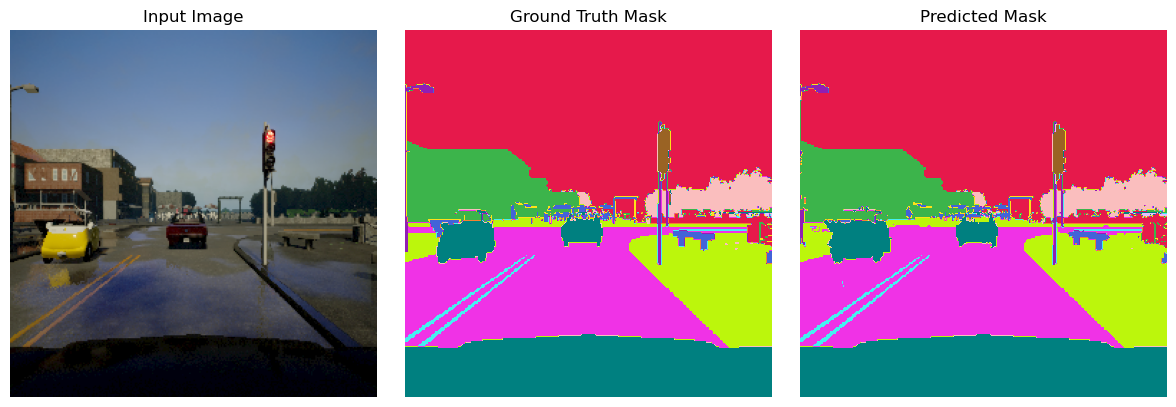

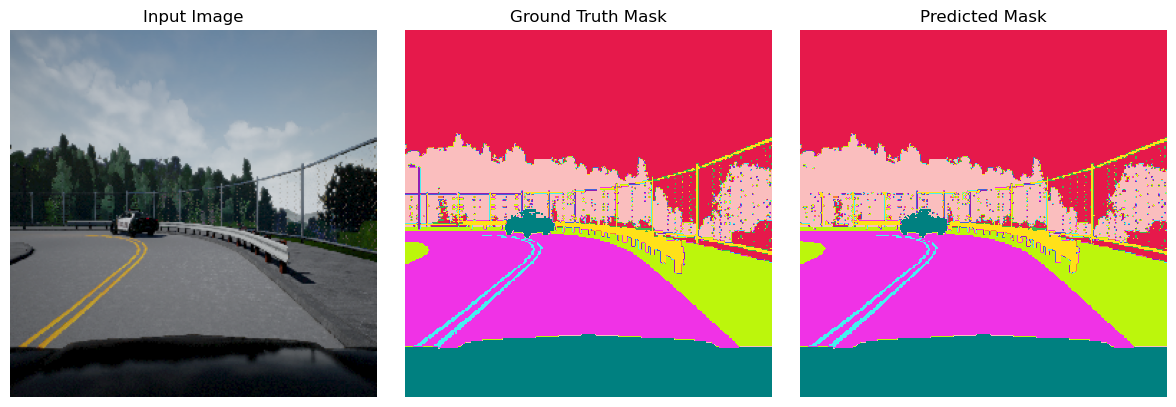

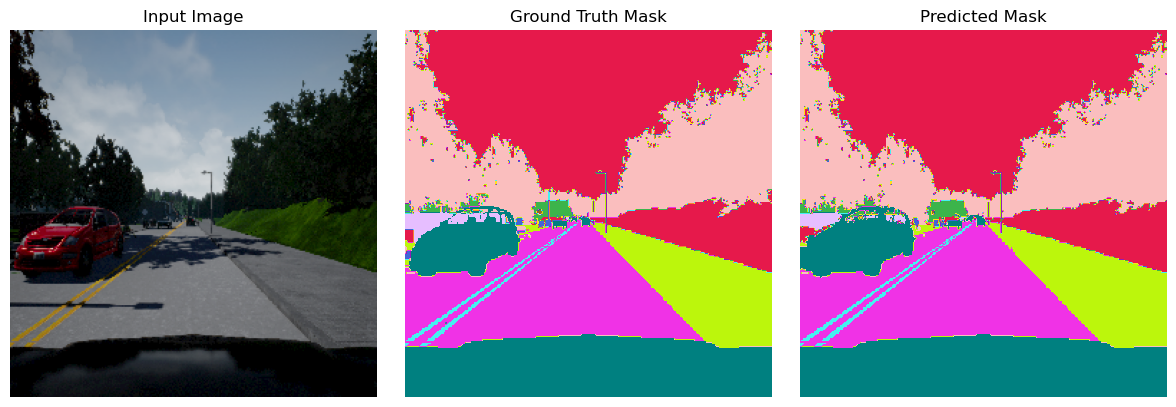

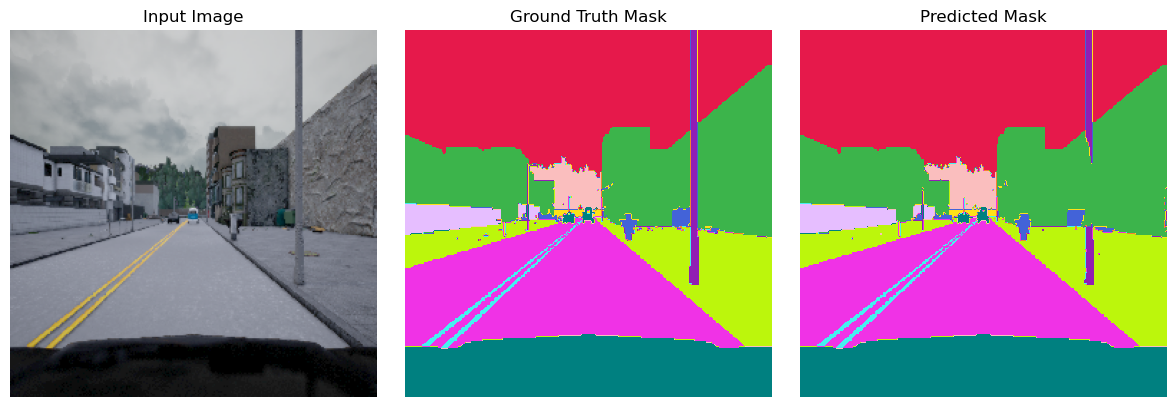

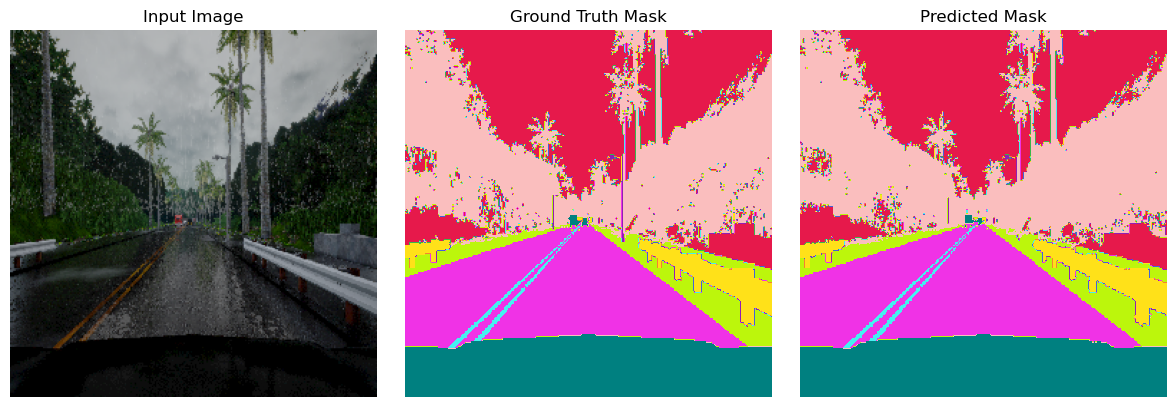

In [23]:
evaluate_and_visualize(vanilla_unet_trained, test_loader, device)

<img src="figures/vanilla_unet.png"><img>

## 3.2 U-Net without skip connections

In [12]:
class Up_noskip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(out_channels, out_channels)

    def forward(self, x_decoder):  # x_decoder is from decoder
        x_decoder = self.up(x_decoder)
        return self.conv(x_decoder)

In [13]:
class Vanilla_UNet_NoSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down()
        self.enc1 = DoubleConv(64, 128)
        self.down2 = Down()
        self.enc2 = DoubleConv(128, 256)
        self.down3 = Down()
        self.enc3 = DoubleConv(256, 512)
        self.down4 = Down()
        self.enc4 = DoubleConv(512, 1024)
        self.up1 = Up_noskip(1024, 512)
        self.up2 = Up_noskip(512, 256)
        self.up3 = Up_noskip(256, 128)
        self.up4 = Up_noskip(128, 64)
        self.outc = out_conv(64, out_channels)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.enc1(x2)
        x4 = self.down2(x3)
        x5 = self.enc2(x4)
        x6 = self.down3(x5)
        x7 = self.enc3(x6)
        x8 = self.down4(x7)
        x9 = self.enc4(x8)

        x10 = self.up1(x9)
        x11 = self.up2(x10)
        x12 = self.up3(x11)
        x13 = self.up4(x12)

        logits = self.outc(x13)

        return logits

In [26]:
vanilla_unet_noskip = Vanilla_UNet_NoSkip(in_channels=3, out_channels=13)
wandb.init(project='Vanilla_UNet',name="No skip connections")
vanilla_unet_noskip_trained = train_model(vanilla_unet_noskip, train_loader, val_loader, device)
wandb.finish()

Validation Epoch 1: 100%|██████████| 25/25 [00:01<00:00, 13.13it/s]


Epoch [1/50], Train Loss: 1.1499, Val Loss: 0.6907, Train mIoU: 0.6403, Val mIoU: 0.7927


Validation Epoch 2: 100%|██████████| 25/25 [00:01<00:00, 13.08it/s]


Epoch [2/50], Train Loss: 0.5664, Val Loss: 0.4505, Train mIoU: 0.8070, Val mIoU: 0.8355


Validation Epoch 3: 100%|██████████| 25/25 [00:01<00:00, 12.61it/s]


Epoch [3/50], Train Loss: 0.4042, Val Loss: 0.4023, Train mIoU: 0.8258, Val mIoU: 0.8060


Validation Epoch 4: 100%|██████████| 25/25 [00:01<00:00, 13.14it/s]


Epoch [4/50], Train Loss: 0.3137, Val Loss: 0.2740, Train mIoU: 0.8415, Val mIoU: 0.8561


Validation Epoch 5: 100%|██████████| 25/25 [00:01<00:00, 13.36it/s]


Epoch [5/50], Train Loss: 0.2601, Val Loss: 0.2493, Train mIoU: 0.8529, Val mIoU: 0.8550


Validation Epoch 6: 100%|██████████| 25/25 [00:01<00:00, 13.18it/s]


Epoch [6/50], Train Loss: 0.2245, Val Loss: 0.2182, Train mIoU: 0.8601, Val mIoU: 0.8616


Validation Epoch 7: 100%|██████████| 25/25 [00:01<00:00, 12.86it/s]


Epoch [7/50], Train Loss: 0.1880, Val Loss: 0.1766, Train mIoU: 0.8735, Val mIoU: 0.8830


Validation Epoch 8: 100%|██████████| 25/25 [00:01<00:00, 13.33it/s]


Epoch [8/50], Train Loss: 0.1660, Val Loss: 0.1706, Train mIoU: 0.8832, Val mIoU: 0.8833


Validation Epoch 9: 100%|██████████| 25/25 [00:01<00:00, 13.08it/s]


Epoch [9/50], Train Loss: 0.1516, Val Loss: 0.1475, Train mIoU: 0.8877, Val mIoU: 0.8903


Validation Epoch 10: 100%|██████████| 25/25 [00:01<00:00, 13.23it/s]


Epoch [10/50], Train Loss: 0.1363, Val Loss: 0.1405, Train mIoU: 0.8949, Val mIoU: 0.8941


Validation Epoch 11: 100%|██████████| 25/25 [00:01<00:00, 13.62it/s]


Epoch [11/50], Train Loss: 0.1262, Val Loss: 0.1339, Train mIoU: 0.8991, Val mIoU: 0.8962


Validation Epoch 12: 100%|██████████| 25/25 [00:01<00:00, 13.12it/s]


Epoch [12/50], Train Loss: 0.1179, Val Loss: 0.1245, Train mIoU: 0.9023, Val mIoU: 0.8988


Validation Epoch 13: 100%|██████████| 25/25 [00:01<00:00, 13.57it/s]


Epoch [13/50], Train Loss: 0.1106, Val Loss: 0.1206, Train mIoU: 0.9060, Val mIoU: 0.9035


Validation Epoch 14: 100%|██████████| 25/25 [00:01<00:00, 13.57it/s]


Epoch [14/50], Train Loss: 0.1100, Val Loss: 0.1218, Train mIoU: 0.9051, Val mIoU: 0.8992


Validation Epoch 15: 100%|██████████| 25/25 [00:01<00:00, 13.57it/s]


Epoch [15/50], Train Loss: 0.1036, Val Loss: 0.1134, Train mIoU: 0.9084, Val mIoU: 0.9052


Validation Epoch 16: 100%|██████████| 25/25 [00:01<00:00, 13.21it/s]


Epoch [16/50], Train Loss: 0.0961, Val Loss: 0.1119, Train mIoU: 0.9132, Val mIoU: 0.9067


Validation Epoch 17: 100%|██████████| 25/25 [00:01<00:00, 13.21it/s]


Epoch [17/50], Train Loss: 0.0929, Val Loss: 0.1102, Train mIoU: 0.9148, Val mIoU: 0.9086


Validation Epoch 18: 100%|██████████| 25/25 [00:01<00:00, 13.28it/s]


Epoch [18/50], Train Loss: 0.0892, Val Loss: 0.1083, Train mIoU: 0.9172, Val mIoU: 0.9061


Validation Epoch 19: 100%|██████████| 25/25 [00:01<00:00, 13.26it/s]


Epoch [19/50], Train Loss: 0.1476, Val Loss: 0.1775, Train mIoU: 0.8831, Val mIoU: 0.8643


Validation Epoch 20: 100%|██████████| 25/25 [00:01<00:00, 13.40it/s]


Epoch [20/50], Train Loss: 0.1135, Val Loss: 0.1109, Train mIoU: 0.8994, Val mIoU: 0.9052


Validation Epoch 21: 100%|██████████| 25/25 [00:01<00:00, 13.30it/s]


Epoch [21/50], Train Loss: 0.0873, Val Loss: 0.1020, Train mIoU: 0.9171, Val mIoU: 0.9112


Validation Epoch 22: 100%|██████████| 25/25 [00:01<00:00, 13.42it/s]


Epoch [22/50], Train Loss: 0.0809, Val Loss: 0.1018, Train mIoU: 0.9219, Val mIoU: 0.9127


Validation Epoch 23: 100%|██████████| 25/25 [00:01<00:00, 13.38it/s]


Epoch [23/50], Train Loss: 0.0780, Val Loss: 0.1014, Train mIoU: 0.9239, Val mIoU: 0.9135


Validation Epoch 24: 100%|██████████| 25/25 [00:01<00:00, 13.29it/s]


Epoch [24/50], Train Loss: 0.0763, Val Loss: 0.1008, Train mIoU: 0.9255, Val mIoU: 0.9131


Validation Epoch 25: 100%|██████████| 25/25 [00:01<00:00, 13.38it/s]


Epoch [25/50], Train Loss: 0.0747, Val Loss: 0.1018, Train mIoU: 0.9263, Val mIoU: 0.9129


Validation Epoch 26: 100%|██████████| 25/25 [00:01<00:00, 12.91it/s]


Epoch [26/50], Train Loss: 0.0739, Val Loss: 0.0994, Train mIoU: 0.9270, Val mIoU: 0.9149


Validation Epoch 27: 100%|██████████| 25/25 [00:01<00:00, 13.40it/s]


Epoch [27/50], Train Loss: 0.0731, Val Loss: 0.0993, Train mIoU: 0.9273, Val mIoU: 0.9151


Validation Epoch 28: 100%|██████████| 25/25 [00:01<00:00, 13.47it/s]


Epoch [28/50], Train Loss: 0.1064, Val Loss: 0.1016, Train mIoU: 0.9042, Val mIoU: 0.9115


Validation Epoch 29: 100%|██████████| 25/25 [00:01<00:00, 13.40it/s]


Epoch [29/50], Train Loss: 0.0741, Val Loss: 0.0977, Train mIoU: 0.9259, Val mIoU: 0.9158


Validation Epoch 30: 100%|██████████| 25/25 [00:01<00:00, 13.46it/s]


Epoch [30/50], Train Loss: 0.0684, Val Loss: 0.0973, Train mIoU: 0.9309, Val mIoU: 0.9159


Validation Epoch 31: 100%|██████████| 25/25 [00:01<00:00, 13.35it/s]


Epoch [31/50], Train Loss: 0.0666, Val Loss: 0.0977, Train mIoU: 0.9327, Val mIoU: 0.9170


Validation Epoch 32: 100%|██████████| 25/25 [00:01<00:00, 13.48it/s]


Epoch [32/50], Train Loss: 0.0656, Val Loss: 0.0983, Train mIoU: 0.9333, Val mIoU: 0.9167


Validation Epoch 33: 100%|██████████| 25/25 [00:01<00:00, 13.18it/s]


Epoch [33/50], Train Loss: 0.0648, Val Loss: 0.0993, Train mIoU: 0.9336, Val mIoU: 0.9164


Validation Epoch 34: 100%|██████████| 25/25 [00:01<00:00, 13.51it/s]


Epoch [34/50], Train Loss: 0.0654, Val Loss: 0.0993, Train mIoU: 0.9335, Val mIoU: 0.9156


Validation Epoch 35: 100%|██████████| 25/25 [00:01<00:00, 13.62it/s]


Epoch [35/50], Train Loss: 0.0644, Val Loss: 0.0984, Train mIoU: 0.9339, Val mIoU: 0.9172


Validation Epoch 36: 100%|██████████| 25/25 [00:01<00:00, 13.31it/s]


Epoch [36/50], Train Loss: 0.0631, Val Loss: 0.0995, Train mIoU: 0.9351, Val mIoU: 0.9173


Validation Epoch 37: 100%|██████████| 25/25 [00:01<00:00, 13.16it/s]


Epoch [37/50], Train Loss: 0.0621, Val Loss: 0.0992, Train mIoU: 0.9362, Val mIoU: 0.9177


Validation Epoch 38: 100%|██████████| 25/25 [00:01<00:00, 13.21it/s]


Epoch [38/50], Train Loss: 0.0612, Val Loss: 0.0992, Train mIoU: 0.9368, Val mIoU: 0.9183


Validation Epoch 39: 100%|██████████| 25/25 [00:01<00:00, 13.33it/s]


Epoch [39/50], Train Loss: 0.0608, Val Loss: 0.0998, Train mIoU: 0.9373, Val mIoU: 0.9170


Validation Epoch 40: 100%|██████████| 25/25 [00:01<00:00, 13.35it/s]


Epoch [40/50], Train Loss: 0.0594, Val Loss: 0.0995, Train mIoU: 0.9384, Val mIoU: 0.9170
Early stopping at epoch 40 — no improvement for 10 consecutive epochs.


Evaluating: 100%|██████████| 63/63 [00:04<00:00, 13.83it/s]



Mean IoU on Test Set: 0.9063


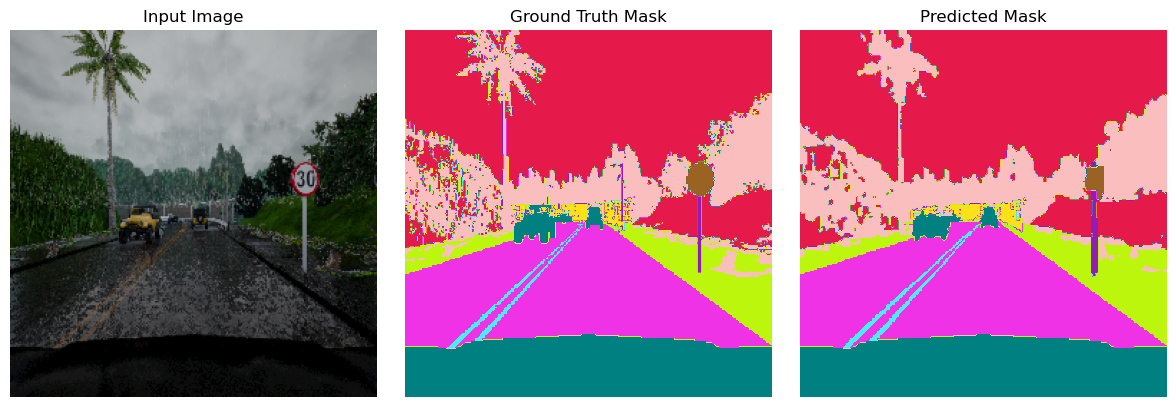

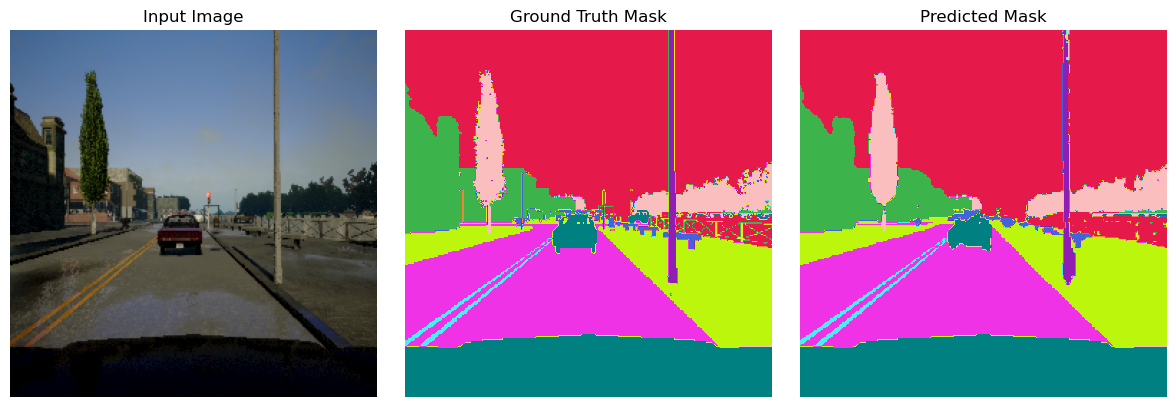

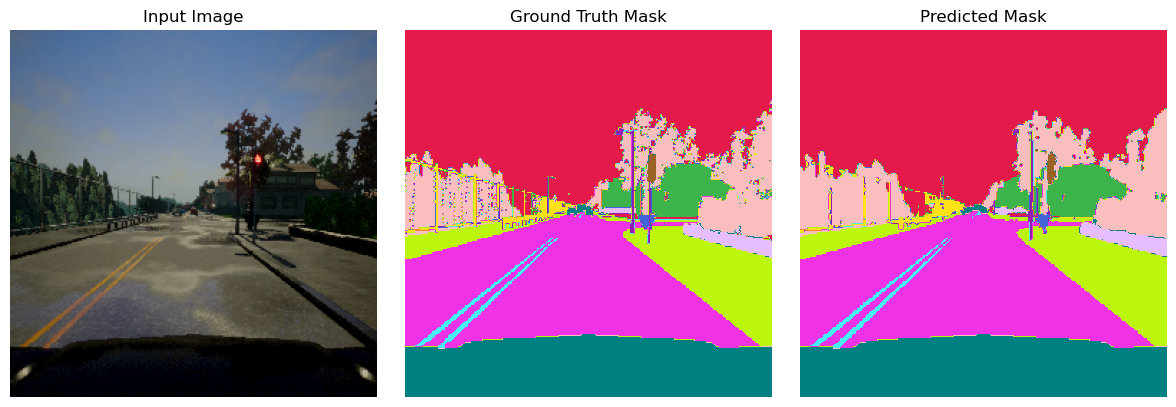

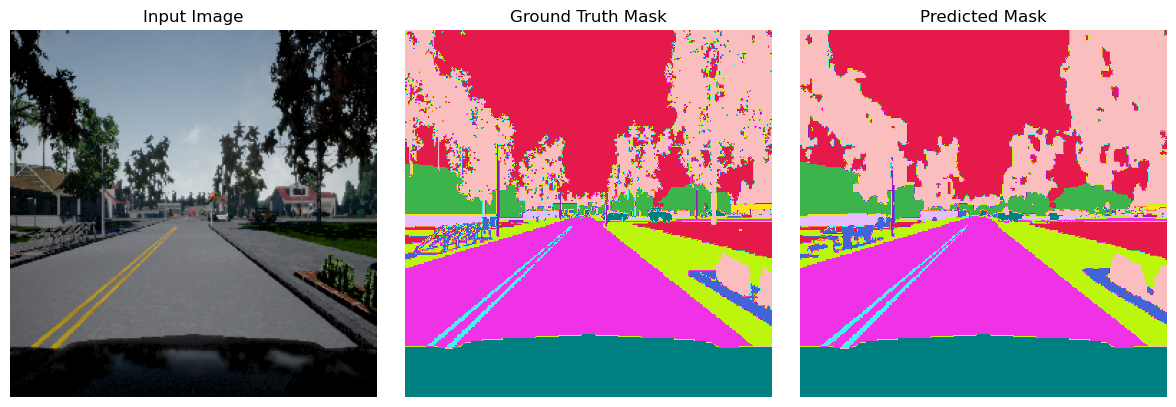

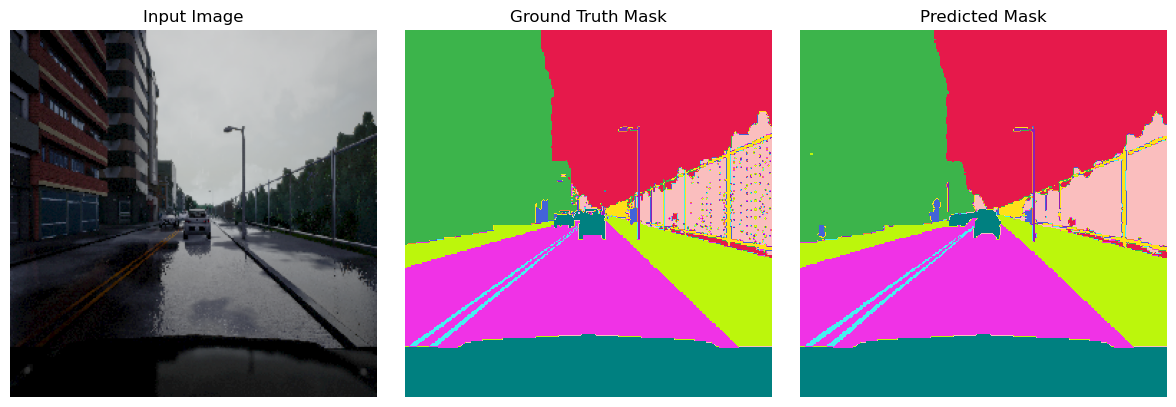

In [27]:
evaluate_and_visualize(vanilla_unet_noskip_trained, test_loader, device)

<img src="figures/no_skip.png"><img>

### What differences do you observe in the visualized results compared to the standard U-Net results? Discuss.

The outputs reveal that the predicted segmentation masks lack clearly defined shapes, instead capturing broad regions with limited detail. Fine-grained structures such as poles and fences are often missed or poorly represented. This highlights the importance of skip connections in preserving spatial detail, enabling the model to accurately reconstruct fine features in the segmentation output.


### Importance of Skip Connections in U-Net

Skip connections are a critical component of the U-Net architecture, enabling effective segmentation by addressing several key challenges:

1. **Preservation of Spatial Details**: As the encoder compresses spatial information, skip connections transfer high-resolution features directly to the decoder, preserving fine details lost during downsampling.

2. **Improved Gradient Flow**: They create shorter paths for gradients, reducing the risk of vanishing gradients and facilitating the training of deeper networks.

3. **Multi-scale Feature Fusion**: By combining low-level spatial features with high-level semantic information, skip connections help produce accurate and context-aware segmentation outputs.

4. **Enhanced Localization**: They restore localization accuracy that is lost in the encoder, leading to sharper boundaries and better detection of small structures.

## 3.3 Residual U-Net 

In [14]:
class ResidualConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        self.skip_conv = nn.Identity()
        if in_channels != out_channels:
            self.skip_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip_conv(x)
        out = self.conv_block(x)
        out += residual
        return self.relu(out)

In [15]:
class Vanilla_Residual_UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.inc = ResidualConv(in_channels, 64)
        self.down1 = Down()
        self.enc1 = ResidualConv(64, 128)
        self.down2 = Down()
        self.enc2 = ResidualConv(128, 256)
        self.down3 = Down()
        self.enc3 = ResidualConv(256, 512)
        self.down4 = Down()
        self.enc4 = ResidualConv(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = out_conv(64, out_channels)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.enc1(x2)
        x4 = self.down2(x3)
        x5 = self.enc2(x4)
        x6 = self.down3(x5)
        x7 = self.enc3(x6)
        x8 = self.down4(x7)
        x9 = self.enc4(x8)

        x10 = self.up1(x9, x7)
        x11 = self.up2(x10, x5)
        x12 = self.up3(x11, x3)
        x13 = self.up4(x12, x1)

        logits = self.outc(x13)

        return logits

In [30]:
vanilla_residual_unet = Vanilla_Residual_UNet(in_channels=3, out_channels=13)
wandb.init(project='Vanilla_UNet',name="Residual convolution blocks")
vanilla_residual_unet_trained = train_model(vanilla_residual_unet, train_loader, val_loader, device)
wandb.finish()

Validation Epoch 1: 100%|██████████| 25/25 [00:02<00:00, 11.36it/s]


Epoch [1/50], Train Loss: 0.8938, Val Loss: 0.5735, Train mIoU: 0.7499, Val mIoU: 0.8587


Validation Epoch 2: 100%|██████████| 25/25 [00:02<00:00, 11.16it/s]


Epoch [2/50], Train Loss: 0.4381, Val Loss: 0.4059, Train mIoU: 0.8605, Val mIoU: 0.8668


Validation Epoch 3: 100%|██████████| 25/25 [00:02<00:00, 11.25it/s]


Epoch [3/50], Train Loss: 0.3001, Val Loss: 0.2698, Train mIoU: 0.8853, Val mIoU: 0.8905


Validation Epoch 4: 100%|██████████| 25/25 [00:02<00:00, 11.33it/s]


Epoch [4/50], Train Loss: 0.2275, Val Loss: 0.2021, Train mIoU: 0.9009, Val mIoU: 0.9125


Validation Epoch 5: 100%|██████████| 25/25 [00:02<00:00, 11.42it/s]


Epoch [5/50], Train Loss: 0.1883, Val Loss: 0.1614, Train mIoU: 0.9089, Val mIoU: 0.9219


Validation Epoch 6: 100%|██████████| 25/25 [00:02<00:00, 11.39it/s]


Epoch [6/50], Train Loss: 0.1481, Val Loss: 0.1361, Train mIoU: 0.9267, Val mIoU: 0.9336


Validation Epoch 7: 100%|██████████| 25/25 [00:02<00:00, 11.25it/s]


Epoch [7/50], Train Loss: 0.1231, Val Loss: 0.1166, Train mIoU: 0.9391, Val mIoU: 0.9425


Validation Epoch 8: 100%|██████████| 25/25 [00:02<00:00, 11.37it/s]


Epoch [8/50], Train Loss: 0.1094, Val Loss: 0.1025, Train mIoU: 0.9426, Val mIoU: 0.9461


Validation Epoch 9: 100%|██████████| 25/25 [00:02<00:00, 11.30it/s]


Epoch [9/50], Train Loss: 0.0933, Val Loss: 0.0927, Train mIoU: 0.9488, Val mIoU: 0.9484


Validation Epoch 10: 100%|██████████| 25/25 [00:02<00:00, 11.28it/s]


Epoch [10/50], Train Loss: 0.0830, Val Loss: 0.0822, Train mIoU: 0.9522, Val mIoU: 0.9526


Validation Epoch 11: 100%|██████████| 25/25 [00:02<00:00, 11.18it/s]


Epoch [11/50], Train Loss: 0.0733, Val Loss: 0.0746, Train mIoU: 0.9564, Val mIoU: 0.9564


Validation Epoch 12: 100%|██████████| 25/25 [00:02<00:00, 11.24it/s]


Epoch [12/50], Train Loss: 0.0982, Val Loss: 0.0835, Train mIoU: 0.9407, Val mIoU: 0.9521


Validation Epoch 13: 100%|██████████| 25/25 [00:02<00:00, 11.36it/s]


Epoch [13/50], Train Loss: 0.0679, Val Loss: 0.0665, Train mIoU: 0.9582, Val mIoU: 0.9597


Validation Epoch 14: 100%|██████████| 25/25 [00:02<00:00, 11.44it/s]


Epoch [14/50], Train Loss: 0.0578, Val Loss: 0.0588, Train mIoU: 0.9642, Val mIoU: 0.9633


Validation Epoch 15: 100%|██████████| 25/25 [00:02<00:00, 11.36it/s]


Epoch [15/50], Train Loss: 0.0528, Val Loss: 0.0554, Train mIoU: 0.9669, Val mIoU: 0.9649


Validation Epoch 16: 100%|██████████| 25/25 [00:02<00:00, 11.17it/s]


Epoch [16/50], Train Loss: 0.0488, Val Loss: 0.0534, Train mIoU: 0.9687, Val mIoU: 0.9651


Validation Epoch 17: 100%|██████████| 25/25 [00:02<00:00, 11.11it/s]


Epoch [17/50], Train Loss: 0.0458, Val Loss: 0.0503, Train mIoU: 0.9702, Val mIoU: 0.9672


Validation Epoch 18: 100%|██████████| 25/25 [00:02<00:00, 11.22it/s]


Epoch [18/50], Train Loss: 0.0437, Val Loss: 0.0493, Train mIoU: 0.9711, Val mIoU: 0.9673


Validation Epoch 19: 100%|██████████| 25/25 [00:02<00:00, 11.30it/s]


Epoch [19/50], Train Loss: 0.0417, Val Loss: 0.0480, Train mIoU: 0.9719, Val mIoU: 0.9681


Validation Epoch 20: 100%|██████████| 25/25 [00:02<00:00, 11.15it/s]


Epoch [20/50], Train Loss: 0.0733, Val Loss: 0.0895, Train mIoU: 0.9524, Val mIoU: 0.9456


Validation Epoch 21: 100%|██████████| 25/25 [00:02<00:00, 11.40it/s]


Epoch [21/50], Train Loss: 0.0596, Val Loss: 0.0500, Train mIoU: 0.9594, Val mIoU: 0.9667


Validation Epoch 22: 100%|██████████| 25/25 [00:02<00:00, 11.36it/s]


Epoch [22/50], Train Loss: 0.0404, Val Loss: 0.0447, Train mIoU: 0.9721, Val mIoU: 0.9697


Validation Epoch 23: 100%|██████████| 25/25 [00:02<00:00, 11.45it/s]


Epoch [23/50], Train Loss: 0.0367, Val Loss: 0.0421, Train mIoU: 0.9746, Val mIoU: 0.9712


Validation Epoch 24: 100%|██████████| 25/25 [00:02<00:00, 11.18it/s]


Epoch [24/50], Train Loss: 0.0345, Val Loss: 0.0417, Train mIoU: 0.9759, Val mIoU: 0.9711


Validation Epoch 25: 100%|██████████| 25/25 [00:02<00:00, 11.32it/s]


Epoch [25/50], Train Loss: 0.0332, Val Loss: 0.0410, Train mIoU: 0.9765, Val mIoU: 0.9717


Validation Epoch 26: 100%|██████████| 25/25 [00:02<00:00, 11.40it/s]


Epoch [26/50], Train Loss: 0.0319, Val Loss: 0.0391, Train mIoU: 0.9772, Val mIoU: 0.9730


Validation Epoch 27: 100%|██████████| 25/25 [00:02<00:00, 11.43it/s]


Epoch [27/50], Train Loss: 0.0308, Val Loss: 0.0400, Train mIoU: 0.9780, Val mIoU: 0.9724


Validation Epoch 28: 100%|██████████| 25/25 [00:02<00:00, 11.26it/s]


Epoch [28/50], Train Loss: 0.0300, Val Loss: 0.0387, Train mIoU: 0.9782, Val mIoU: 0.9731


Validation Epoch 29: 100%|██████████| 25/25 [00:02<00:00, 11.05it/s]


Epoch [29/50], Train Loss: 0.0291, Val Loss: 0.0372, Train mIoU: 0.9788, Val mIoU: 0.9739


Validation Epoch 30: 100%|██████████| 25/25 [00:02<00:00, 11.38it/s]


Epoch [30/50], Train Loss: 0.0279, Val Loss: 0.0375, Train mIoU: 0.9797, Val mIoU: 0.9738


Validation Epoch 31: 100%|██████████| 25/25 [00:02<00:00, 11.39it/s]


Epoch [31/50], Train Loss: 0.0272, Val Loss: 0.0382, Train mIoU: 0.9800, Val mIoU: 0.9731


Validation Epoch 32: 100%|██████████| 25/25 [00:02<00:00, 11.40it/s]


Epoch [32/50], Train Loss: 0.0263, Val Loss: 0.0367, Train mIoU: 0.9805, Val mIoU: 0.9740


Validation Epoch 33: 100%|██████████| 25/25 [00:02<00:00, 11.24it/s]


Epoch [33/50], Train Loss: 0.0258, Val Loss: 0.0360, Train mIoU: 0.9808, Val mIoU: 0.9745


Validation Epoch 34: 100%|██████████| 25/25 [00:02<00:00, 11.27it/s]


Epoch [34/50], Train Loss: 0.0250, Val Loss: 0.0368, Train mIoU: 0.9813, Val mIoU: 0.9746


Validation Epoch 35: 100%|██████████| 25/25 [00:02<00:00, 11.14it/s]


Epoch [35/50], Train Loss: 0.0271, Val Loss: 0.0364, Train mIoU: 0.9796, Val mIoU: 0.9745


Validation Epoch 36: 100%|██████████| 25/25 [00:02<00:00, 11.40it/s]


Epoch [36/50], Train Loss: 0.0239, Val Loss: 0.0348, Train mIoU: 0.9819, Val mIoU: 0.9757


Validation Epoch 37: 100%|██████████| 25/25 [00:02<00:00, 11.24it/s]


Epoch [37/50], Train Loss: 0.0222, Val Loss: 0.0335, Train mIoU: 0.9832, Val mIoU: 0.9763


Validation Epoch 38: 100%|██████████| 25/25 [00:02<00:00, 11.28it/s]


Epoch [38/50], Train Loss: 0.0218, Val Loss: 0.0335, Train mIoU: 0.9835, Val mIoU: 0.9765


Validation Epoch 39: 100%|██████████| 25/25 [00:02<00:00, 11.34it/s]


Epoch [39/50], Train Loss: 0.0212, Val Loss: 0.0337, Train mIoU: 0.9839, Val mIoU: 0.9765


Validation Epoch 40: 100%|██████████| 25/25 [00:02<00:00, 11.27it/s]


Epoch [40/50], Train Loss: 0.0201, Val Loss: 0.0332, Train mIoU: 0.9846, Val mIoU: 0.9769


Validation Epoch 41: 100%|██████████| 25/25 [00:02<00:00, 11.32it/s]


Epoch [41/50], Train Loss: 0.0206, Val Loss: 0.0343, Train mIoU: 0.9843, Val mIoU: 0.9765


Validation Epoch 42: 100%|██████████| 25/25 [00:02<00:00, 11.52it/s]


Epoch [42/50], Train Loss: 0.0197, Val Loss: 0.0339, Train mIoU: 0.9848, Val mIoU: 0.9764


Validation Epoch 43: 100%|██████████| 25/25 [00:02<00:00, 11.39it/s]


Epoch [43/50], Train Loss: 0.0196, Val Loss: 0.0334, Train mIoU: 0.9848, Val mIoU: 0.9770


Validation Epoch 44: 100%|██████████| 25/25 [00:02<00:00, 11.25it/s]


Epoch [44/50], Train Loss: 0.0362, Val Loss: 0.4777, Train mIoU: 0.9760, Val mIoU: 0.7815


Validation Epoch 45: 100%|██████████| 25/25 [00:02<00:00, 11.37it/s]


Epoch [45/50], Train Loss: 0.0594, Val Loss: 0.0390, Train mIoU: 0.9582, Val mIoU: 0.9718


Validation Epoch 46: 100%|██████████| 25/25 [00:02<00:00, 11.36it/s]


Epoch [46/50], Train Loss: 0.0254, Val Loss: 0.0326, Train mIoU: 0.9803, Val mIoU: 0.9767


Validation Epoch 47: 100%|██████████| 25/25 [00:02<00:00, 11.21it/s]


Epoch [47/50], Train Loss: 0.0207, Val Loss: 0.0315, Train mIoU: 0.9839, Val mIoU: 0.9777


Validation Epoch 48: 100%|██████████| 25/25 [00:02<00:00, 11.37it/s]


Epoch [48/50], Train Loss: 0.0186, Val Loss: 0.0314, Train mIoU: 0.9854, Val mIoU: 0.9780


Validation Epoch 49: 100%|██████████| 25/25 [00:02<00:00, 11.27it/s]


Epoch [49/50], Train Loss: 0.0175, Val Loss: 0.0313, Train mIoU: 0.9862, Val mIoU: 0.9784


Validation Epoch 50: 100%|██████████| 25/25 [00:02<00:00, 11.33it/s]


Epoch [50/50], Train Loss: 0.0167, Val Loss: 0.0319, Train mIoU: 0.9868, Val mIoU: 0.9785


Evaluating: 100%|██████████| 63/63 [00:05<00:00, 11.83it/s]



Mean IoU on Test Set: 0.9762


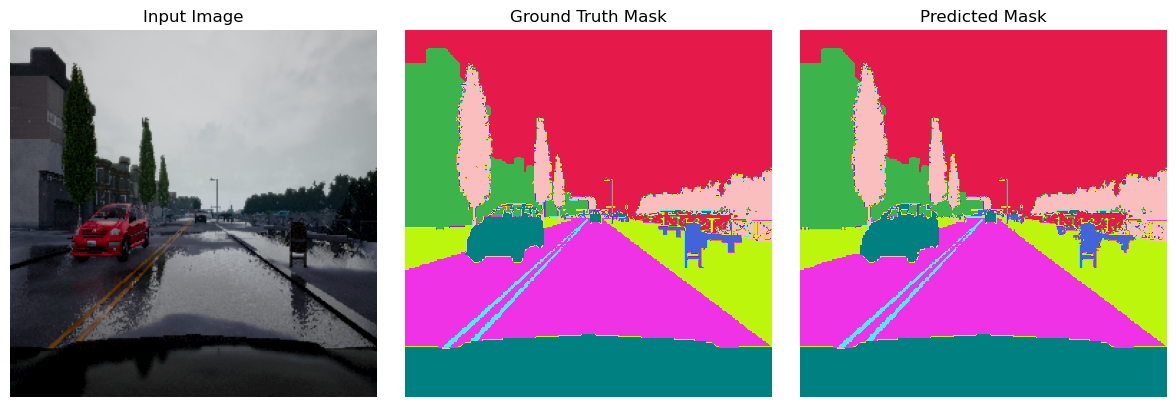

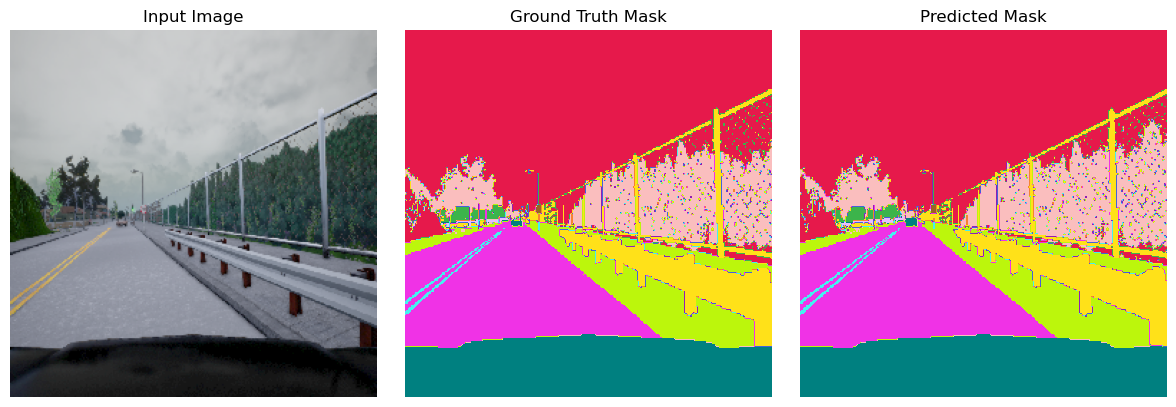

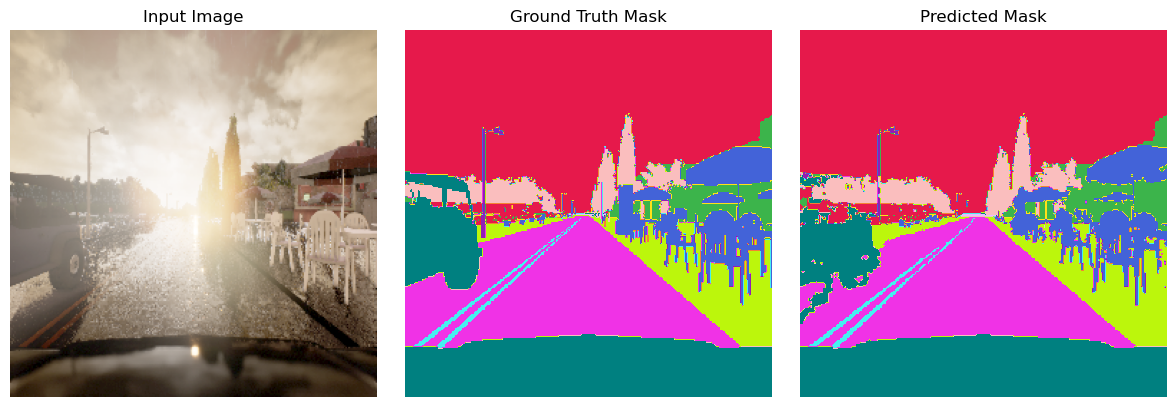

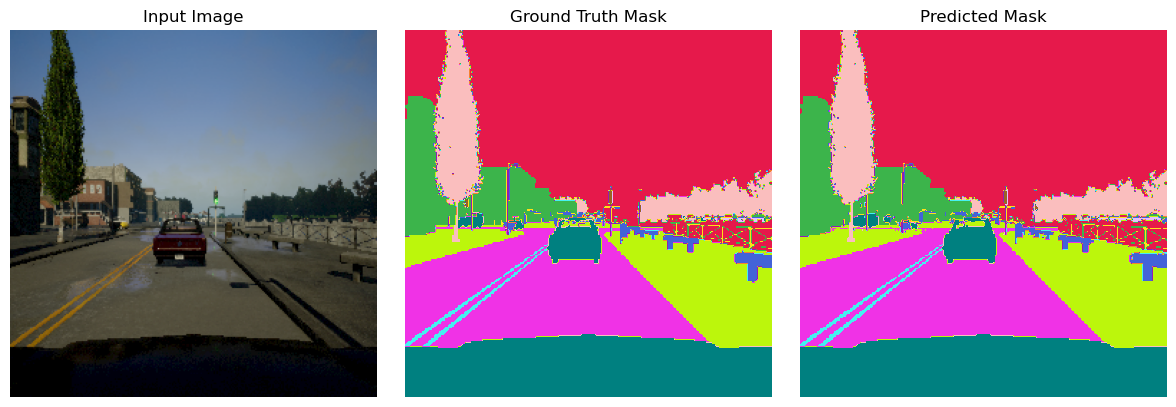

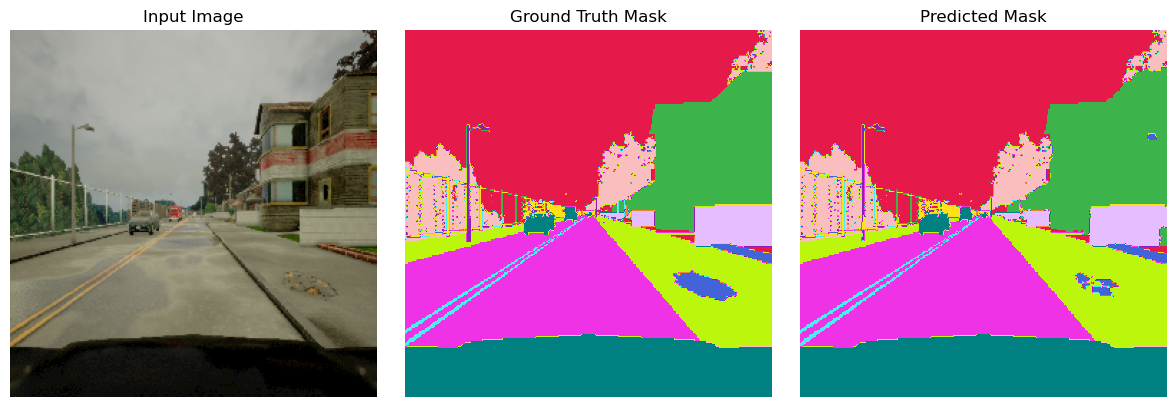

In [31]:
evaluate_and_visualize(vanilla_residual_unet_trained, test_loader, device)

<img src="figures/residual_conv.png"><img>

## 3.4 Gated Attention

In [16]:
class AttentionGate(nn.Module):

    def __init__(self, g_channels, x_channels, inter_channels):

        super().__init__()

        self.W_g = nn.Conv2d(g_channels, inter_channels, kernel_size=1)
        self.W_x = nn.Conv2d(x_channels, inter_channels, kernel_size=1)

        self.psi = nn.Conv2d(inter_channels, 1, kernel_size=1)

        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, g, x):

        # print(f"x shape : {x.shape}")
        # print(f"g shape : {g.shape}")

        
        g1 = self.W_g(g)
        
        x1 = self.W_x(x)
        
        # print(f"x1 shape : {x1.shape}")
        # print(f"g1 shape : {g1.shape}")

        psi = self.relu(g1 + x1)

        psi = self.sigmoid(self.psi(psi))

        alpha = 1
    
        return alpha* x * psi  # Element-wise multiplication

class Attention_Up(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
        self.attention_gate = AttentionGate(out_channels, out_channels, out_channels // 2)

    def forward(self, x_decoder, x_encoder):  # x_decoder is from decoder, x_encoder is from encoder (skip)
        x_decoder = self.up(x_decoder)
        x_attention = self.attention_gate(x_decoder, x_encoder)
        x = torch.cat([x_attention, x_decoder], dim=1)
        return self.conv(x)

In [17]:
class Attention_UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down()
        self.enc1 = DoubleConv(64, 128)
        self.down2 = Down()
        self.enc2 = DoubleConv(128, 256)
        self.down3 = Down()
        self.enc3 = DoubleConv(256, 512)
        self.down4 = Down()
        self.enc4 = DoubleConv(512, 1024)

        self.up1 = Attention_Up(1024, 512)
        self.up2 = Attention_Up(512, 256)
        self.up3 = Attention_Up(256, 128)
        self.up4 = Attention_Up(128, 64)
        
        self.outc = out_conv(64, out_channels)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.enc1(x2)
        x4 = self.down2(x3)
        x5 = self.enc2(x4)
        x6 = self.down3(x5)
        x7 = self.enc3(x6)
        x8 = self.down4(x7)
        x9 = self.enc4(x8)

        x10 = self.up1(x9, x7)
        x11 = self.up2(x10, x5)
        x12 = self.up3(x11, x3)
        x13 = self.up4(x12, x1)

        logits = self.outc(x13)

        return logits

In [18]:
attention_unet = Attention_UNet(in_channels=3, out_channels=13)
wandb.init(project='Vanilla_UNet',name="Gated Attention UNet")
attention_unet_trained = train_model(attention_unet, train_loader, val_loader, device)
wandb.finish()

Validation Epoch 1: 100%|██████████| 25/25 [00:02<00:00, 11.24it/s]


Epoch [1/50], Train Loss: 0.9108, Val Loss: 0.5749, Train mIoU: 0.7525, Val mIoU: 0.8374


Validation Epoch 2: 100%|██████████| 25/25 [00:02<00:00, 11.16it/s]


Epoch [2/50], Train Loss: 0.4508, Val Loss: 0.3804, Train mIoU: 0.8612, Val mIoU: 0.8679


Validation Epoch 3: 100%|██████████| 25/25 [00:02<00:00, 11.19it/s]


Epoch [3/50], Train Loss: 0.3063, Val Loss: 0.2857, Train mIoU: 0.8875, Val mIoU: 0.8852


Validation Epoch 4: 100%|██████████| 25/25 [00:02<00:00, 10.96it/s]


Epoch [4/50], Train Loss: 0.2334, Val Loss: 0.2046, Train mIoU: 0.9020, Val mIoU: 0.9070


Validation Epoch 5: 100%|██████████| 25/25 [00:02<00:00, 11.10it/s]


Epoch [5/50], Train Loss: 0.1840, Val Loss: 0.1687, Train mIoU: 0.9148, Val mIoU: 0.9153


Validation Epoch 6: 100%|██████████| 25/25 [00:02<00:00, 11.29it/s]


Epoch [6/50], Train Loss: 0.1525, Val Loss: 0.1388, Train mIoU: 0.9267, Val mIoU: 0.9340


Validation Epoch 7: 100%|██████████| 25/25 [00:02<00:00, 11.32it/s]


Epoch [7/50], Train Loss: 0.1264, Val Loss: 0.1158, Train mIoU: 0.9373, Val mIoU: 0.9432


Validation Epoch 8: 100%|██████████| 25/25 [00:02<00:00, 11.09it/s]


Epoch [8/50], Train Loss: 0.1066, Val Loss: 0.1020, Train mIoU: 0.9453, Val mIoU: 0.9475


Validation Epoch 9: 100%|██████████| 25/25 [00:02<00:00, 11.18it/s]


Epoch [9/50], Train Loss: 0.0919, Val Loss: 0.0927, Train mIoU: 0.9503, Val mIoU: 0.9493


Validation Epoch 10: 100%|██████████| 25/25 [00:02<00:00, 10.99it/s]


Epoch [10/50], Train Loss: 0.1255, Val Loss: 0.1028, Train mIoU: 0.9290, Val mIoU: 0.9431


Validation Epoch 11: 100%|██████████| 25/25 [00:02<00:00, 11.04it/s]


Epoch [11/50], Train Loss: 0.0853, Val Loss: 0.0861, Train mIoU: 0.9499, Val mIoU: 0.9505


Validation Epoch 12: 100%|██████████| 25/25 [00:02<00:00, 11.02it/s]


Epoch [12/50], Train Loss: 0.0724, Val Loss: 0.0745, Train mIoU: 0.9570, Val mIoU: 0.9560


Validation Epoch 13: 100%|██████████| 25/25 [00:02<00:00, 11.12it/s]


Epoch [13/50], Train Loss: 0.0638, Val Loss: 0.0663, Train mIoU: 0.9613, Val mIoU: 0.9592


Validation Epoch 14: 100%|██████████| 25/25 [00:02<00:00, 11.13it/s]


Epoch [14/50], Train Loss: 0.0582, Val Loss: 0.0656, Train mIoU: 0.9637, Val mIoU: 0.9576


Validation Epoch 15: 100%|██████████| 25/25 [00:02<00:00, 11.25it/s]


Epoch [15/50], Train Loss: 0.0540, Val Loss: 0.0612, Train mIoU: 0.9656, Val mIoU: 0.9610


Validation Epoch 16: 100%|██████████| 25/25 [00:02<00:00, 11.15it/s]


Epoch [16/50], Train Loss: 0.0502, Val Loss: 0.0559, Train mIoU: 0.9678, Val mIoU: 0.9632


Validation Epoch 17: 100%|██████████| 25/25 [00:02<00:00, 11.08it/s]


Epoch [17/50], Train Loss: 0.0474, Val Loss: 0.0604, Train mIoU: 0.9691, Val mIoU: 0.9618


Validation Epoch 18: 100%|██████████| 25/25 [00:02<00:00, 11.24it/s]


Epoch [18/50], Train Loss: 0.0742, Val Loss: 0.0784, Train mIoU: 0.9516, Val mIoU: 0.9498


Validation Epoch 19: 100%|██████████| 25/25 [00:02<00:00, 11.29it/s]


Epoch [19/50], Train Loss: 0.0522, Val Loss: 0.0528, Train mIoU: 0.9647, Val mIoU: 0.9636


Validation Epoch 20: 100%|██████████| 25/25 [00:02<00:00, 11.09it/s]


Epoch [20/50], Train Loss: 0.0418, Val Loss: 0.0496, Train mIoU: 0.9714, Val mIoU: 0.9666


Validation Epoch 21: 100%|██████████| 25/25 [00:02<00:00, 11.30it/s]


Epoch [21/50], Train Loss: 0.0388, Val Loss: 0.0469, Train mIoU: 0.9732, Val mIoU: 0.9679


Validation Epoch 22: 100%|██████████| 25/25 [00:02<00:00, 11.37it/s]


Epoch [22/50], Train Loss: 0.0369, Val Loss: 0.0449, Train mIoU: 0.9742, Val mIoU: 0.9691


Validation Epoch 23: 100%|██████████| 25/25 [00:02<00:00, 10.87it/s]


Epoch [23/50], Train Loss: 0.0350, Val Loss: 0.0451, Train mIoU: 0.9754, Val mIoU: 0.9692


Validation Epoch 24: 100%|██████████| 25/25 [00:02<00:00, 11.11it/s]


Epoch [24/50], Train Loss: 0.0578, Val Loss: 0.0588, Train mIoU: 0.9602, Val mIoU: 0.9604


Validation Epoch 25: 100%|██████████| 25/25 [00:02<00:00, 11.24it/s]


Epoch [25/50], Train Loss: 0.0376, Val Loss: 0.0421, Train mIoU: 0.9734, Val mIoU: 0.9701


Validation Epoch 26: 100%|██████████| 25/25 [00:02<00:00, 11.20it/s]


Epoch [26/50], Train Loss: 0.0321, Val Loss: 0.0409, Train mIoU: 0.9770, Val mIoU: 0.9710


Validation Epoch 27: 100%|██████████| 25/25 [00:02<00:00, 11.01it/s]


Epoch [27/50], Train Loss: 0.0341, Val Loss: 0.0744, Train mIoU: 0.9749, Val mIoU: 0.9509


Validation Epoch 28: 100%|██████████| 25/25 [00:02<00:00, 11.11it/s]


Epoch [28/50], Train Loss: 0.0354, Val Loss: 0.0396, Train mIoU: 0.9743, Val mIoU: 0.9716


Validation Epoch 29: 100%|██████████| 25/25 [00:02<00:00, 11.32it/s]


Epoch [29/50], Train Loss: 0.0288, Val Loss: 0.0387, Train mIoU: 0.9789, Val mIoU: 0.9722


Validation Epoch 30: 100%|██████████| 25/25 [00:02<00:00, 11.11it/s]


Epoch [30/50], Train Loss: 0.0275, Val Loss: 0.0382, Train mIoU: 0.9798, Val mIoU: 0.9725


Validation Epoch 31: 100%|██████████| 25/25 [00:02<00:00, 11.13it/s]


Epoch [31/50], Train Loss: 0.0263, Val Loss: 0.0377, Train mIoU: 0.9805, Val mIoU: 0.9729


Validation Epoch 32: 100%|██████████| 25/25 [00:02<00:00, 11.25it/s]


Epoch [32/50], Train Loss: 0.0261, Val Loss: 0.0406, Train mIoU: 0.9807, Val mIoU: 0.9715


Validation Epoch 33: 100%|██████████| 25/25 [00:02<00:00, 11.12it/s]


Epoch [33/50], Train Loss: 0.0253, Val Loss: 0.0381, Train mIoU: 0.9811, Val mIoU: 0.9725


Validation Epoch 34: 100%|██████████| 25/25 [00:02<00:00, 11.14it/s]


Epoch [34/50], Train Loss: 0.0243, Val Loss: 0.0372, Train mIoU: 0.9817, Val mIoU: 0.9732


Validation Epoch 35: 100%|██████████| 25/25 [00:02<00:00, 11.23it/s]


Epoch [35/50], Train Loss: 0.0258, Val Loss: 0.0380, Train mIoU: 0.9803, Val mIoU: 0.9730


Validation Epoch 36: 100%|██████████| 25/25 [00:02<00:00, 11.31it/s]


Epoch [36/50], Train Loss: 0.0283, Val Loss: 0.0752, Train mIoU: 0.9791, Val mIoU: 0.9537


Validation Epoch 37: 100%|██████████| 25/25 [00:02<00:00, 11.09it/s]


Epoch [37/50], Train Loss: 0.0335, Val Loss: 0.0362, Train mIoU: 0.9752, Val mIoU: 0.9737


Validation Epoch 38: 100%|██████████| 25/25 [00:02<00:00, 11.11it/s]


Epoch [38/50], Train Loss: 0.0229, Val Loss: 0.0352, Train mIoU: 0.9825, Val mIoU: 0.9745


Validation Epoch 39: 100%|██████████| 25/25 [00:02<00:00, 10.92it/s]


Epoch [39/50], Train Loss: 0.0214, Val Loss: 0.0346, Train mIoU: 0.9836, Val mIoU: 0.9752


Validation Epoch 40: 100%|██████████| 25/25 [00:02<00:00, 11.31it/s]


Epoch [40/50], Train Loss: 0.0203, Val Loss: 0.0360, Train mIoU: 0.9843, Val mIoU: 0.9742


Validation Epoch 41: 100%|██████████| 25/25 [00:02<00:00, 11.28it/s]


Epoch [41/50], Train Loss: 0.0206, Val Loss: 0.0350, Train mIoU: 0.9838, Val mIoU: 0.9747


Validation Epoch 42: 100%|██████████| 25/25 [00:02<00:00, 11.32it/s]


Epoch [42/50], Train Loss: 0.0195, Val Loss: 0.0350, Train mIoU: 0.9848, Val mIoU: 0.9753


Validation Epoch 43: 100%|██████████| 25/25 [00:02<00:00, 11.26it/s]


Epoch [43/50], Train Loss: 0.0190, Val Loss: 0.0343, Train mIoU: 0.9852, Val mIoU: 0.9758


Validation Epoch 44: 100%|██████████| 25/25 [00:02<00:00, 11.30it/s]


Epoch [44/50], Train Loss: 0.0187, Val Loss: 0.0360, Train mIoU: 0.9854, Val mIoU: 0.9747


Validation Epoch 45: 100%|██████████| 25/25 [00:02<00:00, 10.94it/s]


Epoch [45/50], Train Loss: 0.0188, Val Loss: 0.0352, Train mIoU: 0.9848, Val mIoU: 0.9756


Validation Epoch 46: 100%|██████████| 25/25 [00:02<00:00, 11.26it/s]


Epoch [46/50], Train Loss: 0.0182, Val Loss: 0.0357, Train mIoU: 0.9856, Val mIoU: 0.9751


Validation Epoch 47: 100%|██████████| 25/25 [00:02<00:00, 11.30it/s]


Epoch [47/50], Train Loss: 0.0601, Val Loss: 0.0637, Train mIoU: 0.9599, Val mIoU: 0.9585


Validation Epoch 48: 100%|██████████| 25/25 [00:02<00:00, 11.26it/s]


Epoch [48/50], Train Loss: 0.0321, Val Loss: 0.0350, Train mIoU: 0.9759, Val mIoU: 0.9745


Validation Epoch 49: 100%|██████████| 25/25 [00:02<00:00, 11.33it/s]


Epoch [49/50], Train Loss: 0.0207, Val Loss: 0.0334, Train mIoU: 0.9837, Val mIoU: 0.9756


Validation Epoch 50: 100%|██████████| 25/25 [00:02<00:00, 11.26it/s]


Epoch [50/50], Train Loss: 0.0190, Val Loss: 0.0326, Train mIoU: 0.9850, Val mIoU: 0.9768


Evaluating: 100%|██████████| 63/63 [00:06<00:00,  9.60it/s]



Mean IoU on Test Set: 0.9765


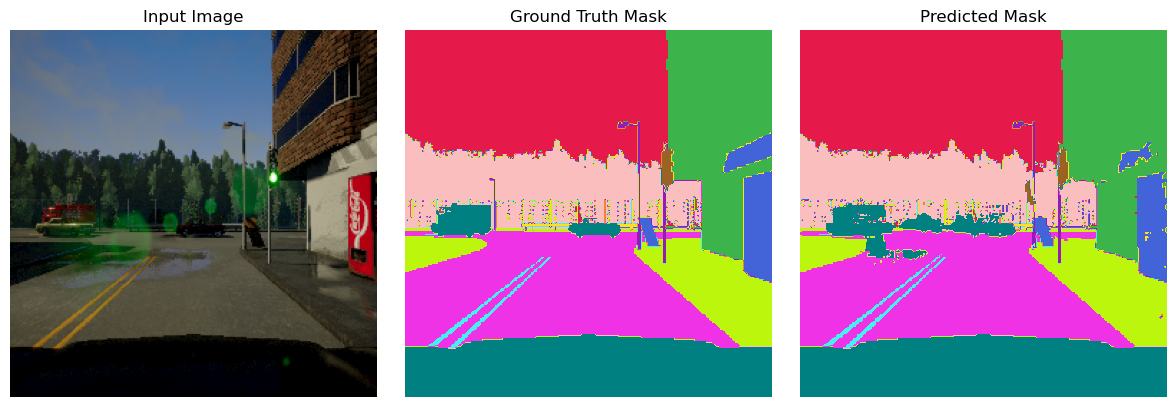

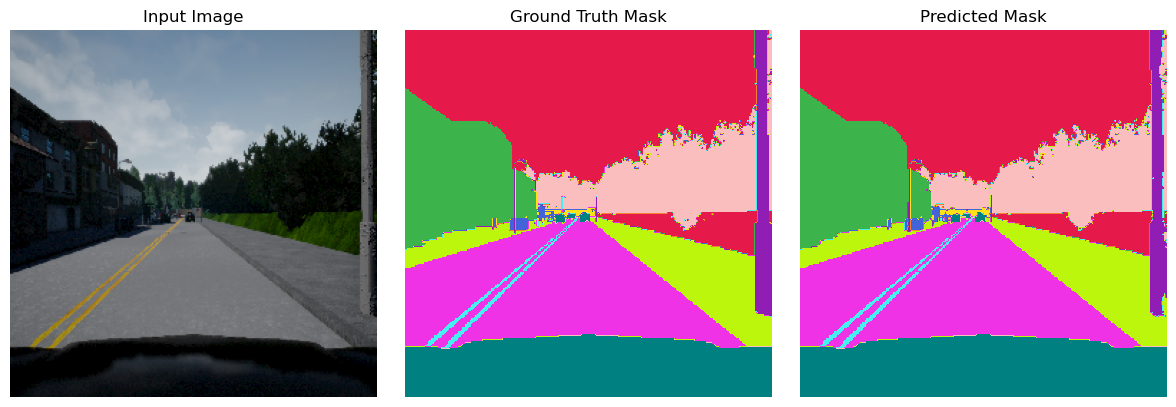

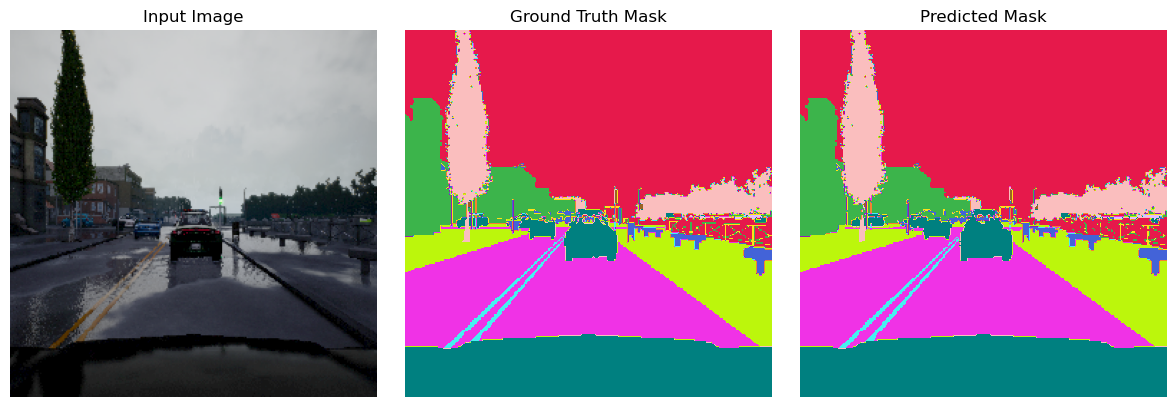

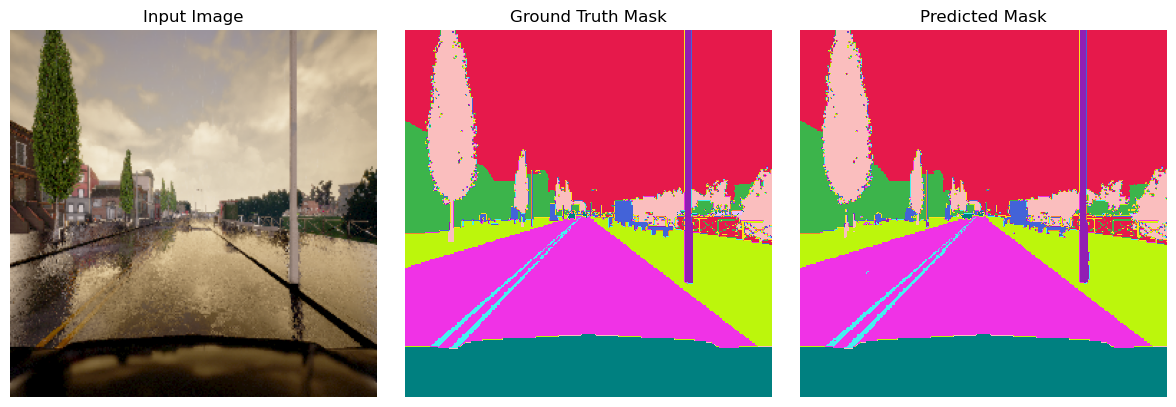

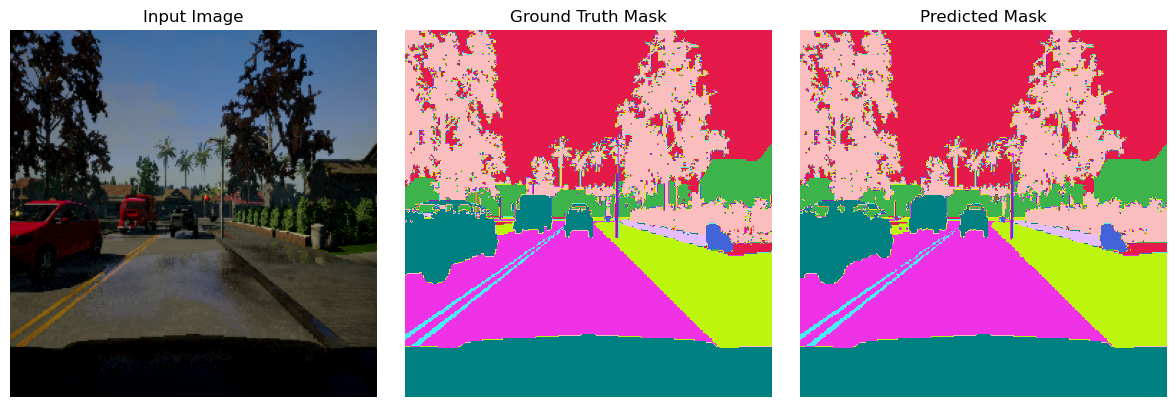

In [19]:
evaluate_and_visualize(attention_unet_trained, test_loader, device)

<img src="figures/gated.png"><img>

### What are some advantages of using Attention gates as per the paper? How does gating signal at skip connections help in improved performance?

Attention gates in the "Attention U-Net" architecture offer several significant advantages:

1. Automatic Feature Selection

Attention gates automatically learn to focus on relevant target structures while suppressing irrelevant regions. This selective focus allows the network to identify and emphasize important features even when they occupy a small portion of the input image, which is particularly valuable for pancreas segmentation where the target organ represents only 1-2% of the abdominal CT volume.

2. Noise and Background Suppression

By generating attention coefficients that weight feature maps, attention gates effectively suppress responses in irrelevant background regions. This filtering mechanism reduces false positives in areas distant from the target structure, improving overall segmentation accuracy without requiring additional training data.

### How Gating Signals Improve Performance

The gating mechanism at skip connections works through several key mechanisms:

1.⁠ ⁠*Contextual Guidance*: Gating signals from deeper layers (which contain more semantic information) are used to filter feature maps from shallow layers (which contain more spatial detail). This allows high-level information to guide the selection of relevant low-level features.

2.⁠ ⁠*Adaptive Feature Refinement*: The multiplicative attention coefficients adaptively scale features at skip connections, highlighting salient features while suppressing irrelevant ones before they're passed to the decoder.

3.⁠ ⁠*Gradient Flow Enhancement*: Beyond improving forward pass information, attention gates also create more direct paths for gradient flow during backpropagation between output and input nodes, contributing to more effective training.



### What differences in results do you observe as compared to the standard U-Net results? Discuss.

Attention allows the model to account for the details in the various segmentation masks. It performs significantly better at identifying poles, car frames, fences, and other minor details that are missed out by other ablations.

**Improved localization of small objects**

Attention enables the model to better capture thin and small structures like poles, traffic signs, fences, or edges of car frames, which are typically underrepresented or even missed entirely by standard U-Net or its no-skip variant.

**Reduced confusion in cluttered regions** 

In scenes where there are overlapping or closely spaced objects, attention helps the model distinguish between adjacent regions more effectively. This reduces misclassification in visually complex areas.

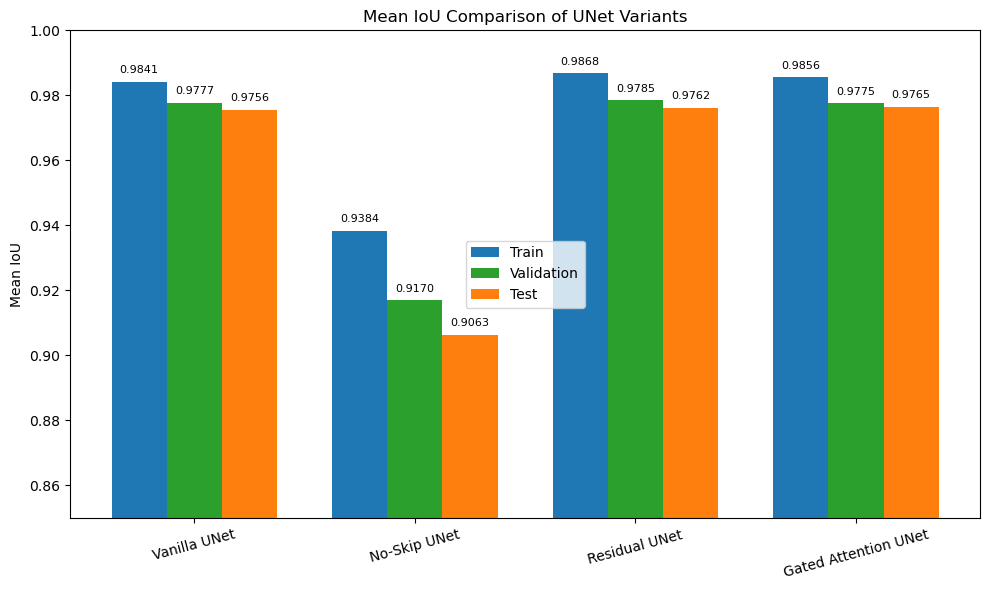

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = [
    "Vanilla UNet",
    "No-Skip UNet",
    "Residual UNet",
    "Gated Attention UNet"
]

train_scores = [0.98413, 0.93842, 0.98679, 0.98556]
val_scores = [0.9777, 0.917, 0.97847, 0.9775]
test_scores = [0.9756, 0.9063, 0.9762, 0.9765]

x = np.arange(len(models)) 
width = 0.25 

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(x - width, train_scores, width, label='Train', color='#1f77b4')
bar2 = ax.bar(x, val_scores, width, label='Validation', color='#2ca02c')
bar3 = ax.bar(x + width, test_scores, width, label='Test', color='#ff7f0e')

# Labels, titles, ticks
ax.set_ylabel('Mean IoU')
ax.set_title('Mean IoU Comparison of UNet Variants')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.set_ylim(0.85, 1.0)
ax.legend()

# Annotate bar values
for bars in [bar1, bar2, bar3]:
    for bar in bars:
        yval = bar.get_height()
        if not np.isnan(yval):
            ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.002, f'{yval:.4f}',
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()
